In [1]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X,y = fetch_olivetti_faces(return_X_y=True) # stores locally the first time and then uses local copy



In [2]:
#dataset is small so use stratified sampling to ensure that the 40 people photographed 10 times are equally represented in the train, test and validation sets
X_train, X_other, y_train, y_other = train_test_split(X, y, random_state=42, stratify=y, train_size=0.6)
X_test, X_validation, y_test, y_validation = train_test_split(X_other, y_other, random_state=42, stratify=y_other, train_size=0.5) #test and validation are 0.2 each


In [3]:
from sklearn.decomposition import PCA

pca = PCA(0.99) #99% explained variance
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_validation)
X_test_pca = pca.transform(X_test)

pca.n_components_

177

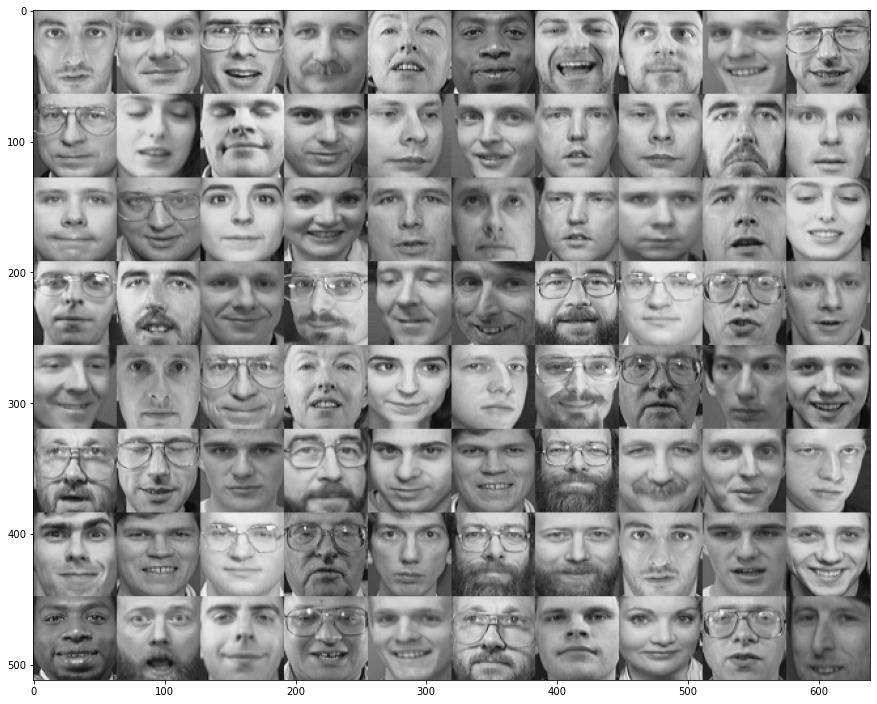

In [4]:
import numpy as np
def show_faces(instances, images_per_row=10):

    images_per_row = min(len(instances),images_per_row)
    nrows = (len(instances) -1)// images_per_row 
    nrows += 1
    row_images =[]
    images = [instance.reshape((64,64)) for instance in instances]
    for row in range(nrows):
        row_image = images[row*images_per_row : (row+1)*images_per_row ]
        row_images.append(np.concatenate(row_image,axis=1))
    
    image = np.concatenate(row_images,axis=0)
    plt.figure(figsize=(15,15))
    plt.imshow(image, cmap="binary_r")
    plt.show()

show_faces(X_validation)

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette = []

for k in range(2,150):
    if k%5 == 0:
        print(f"k= {k}")
    clr = KMeans(n_clusters=k,random_state=42) # The dataset is pre-scaled
    labels = clr.fit_predict(X_train_pca)
    silhouette.append(silhouette_score(X_train_pca,labels))

print(silhouette)

k= 5
k= 10
k= 15
k= 20
k= 25
k= 30
k= 35
k= 40
k= 45
k= 50
k= 55
k= 60
k= 65
k= 70
k= 75
k= 80
k= 85
k= 90
k= 95
k= 100
k= 105
k= 110
k= 115
k= 120
k= 125
k= 130
k= 135
k= 140
k= 145
[0.14910711, 0.1237973, 0.109834604, 0.102782756, 0.09606291, 0.100667216, 0.10737131, 0.09371087, 0.09371101, 0.09232386, 0.09282436, 0.09147628, 0.095686756, 0.102952145, 0.1006519, 0.10574063, 0.104389794, 0.105539285, 0.113177076, 0.102650434, 0.11643899, 0.11504885, 0.115632564, 0.1173309, 0.12633565, 0.11529959, 0.13248716, 0.12406009, 0.12839477, 0.1285602, 0.12712805, 0.1360879, 0.13892749, 0.13860403, 0.14270131, 0.14012796, 0.1378238, 0.13850166, 0.1499323, 0.15299414, 0.15342754, 0.14634605, 0.16107479, 0.155304, 0.15902112, 0.16311435, 0.16131769, 0.16026415, 0.16878885, 0.16739897, 0.17043677, 0.17199382, 0.1764624, 0.1707243, 0.18203712, 0.18094118, 0.18233353, 0.17321773, 0.17478934, 0.17799447, 0.18315932, 0.18817265, 0.19322665, 0.19254708, 0.17914763, 0.19246951, 0.19089188, 0.1856075, 0.

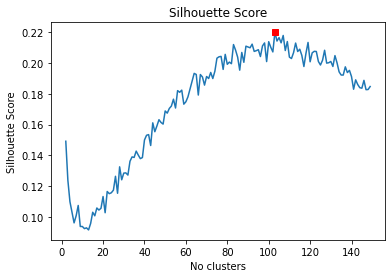

Max silhouette: 0.220 achieved for k=103


In [6]:
plt.plot(range(2,150),silhouette)
plt.title("Silhouette Score")
plt.xlabel("No clusters")
plt.ylabel("Silhouette Score")
best_k = np.argmax(silhouette) +2
max_score = max(silhouette)
plt.plot(best_k, max_score, "rs")


plt.show()
print(f"Max silhouette: {max_score:.3f} achieved for k={best_k}")

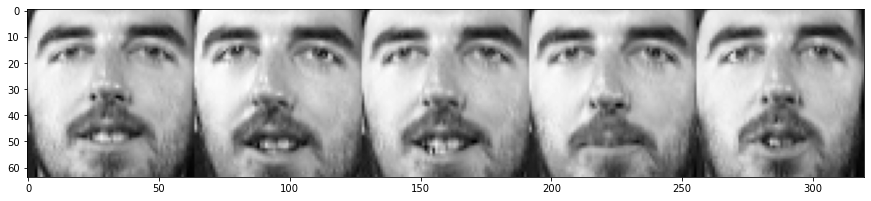

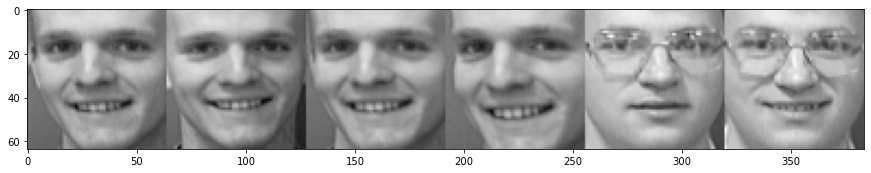

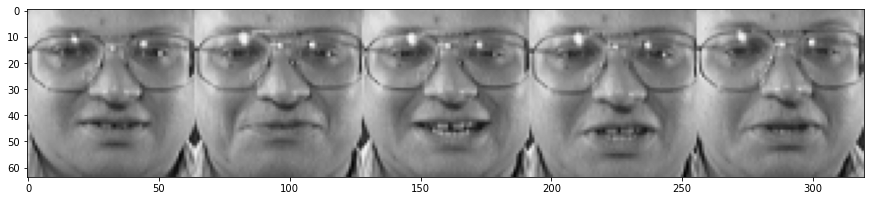

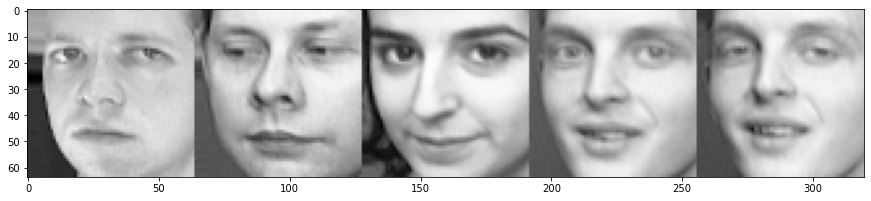

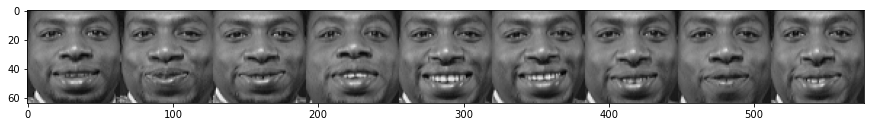

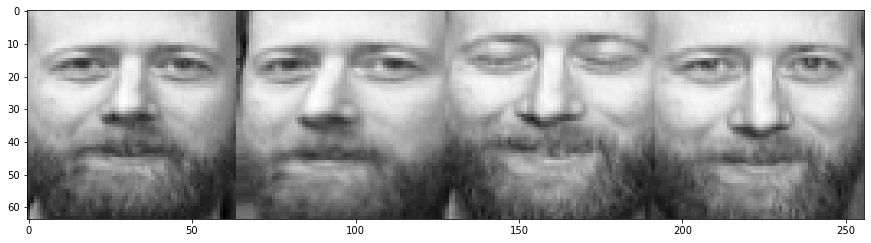

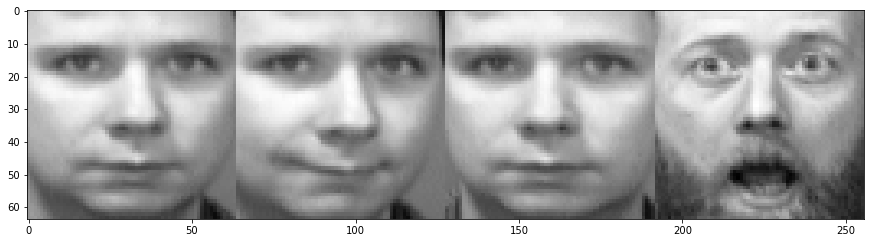

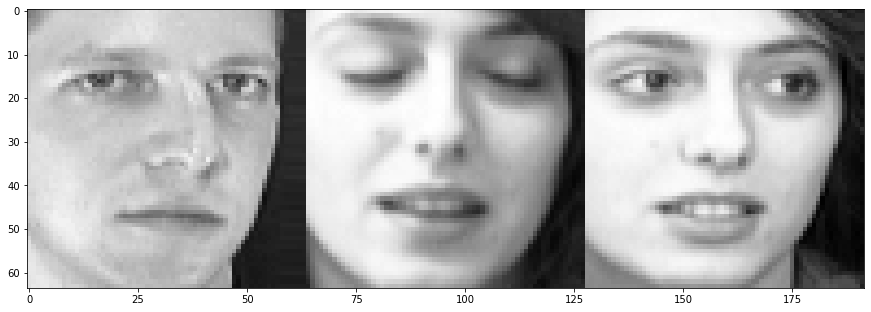

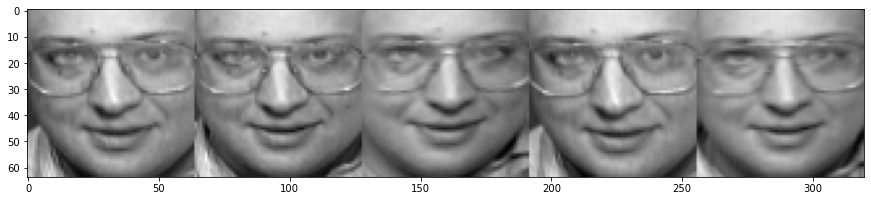

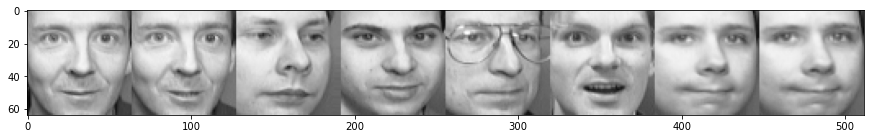

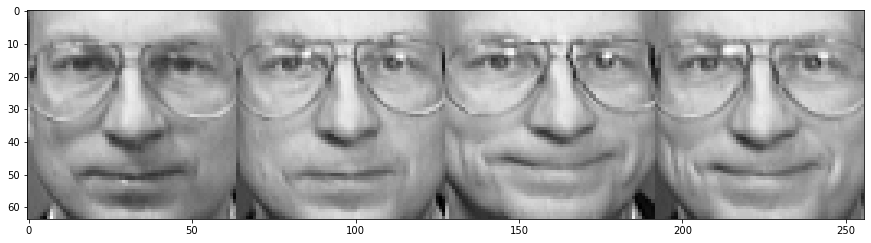

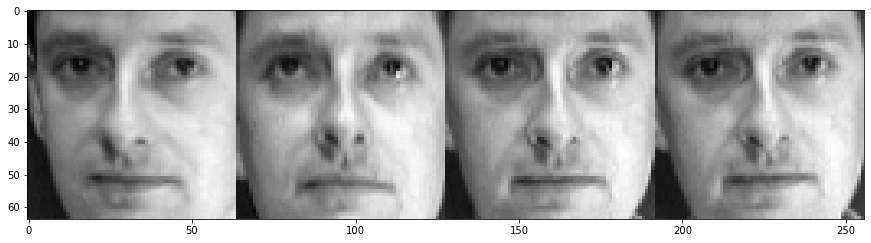

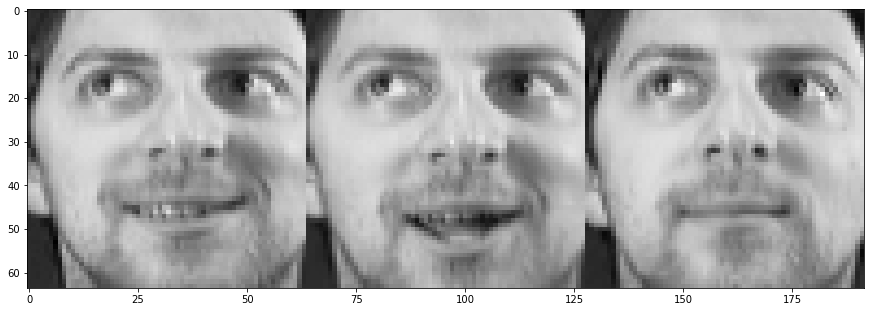

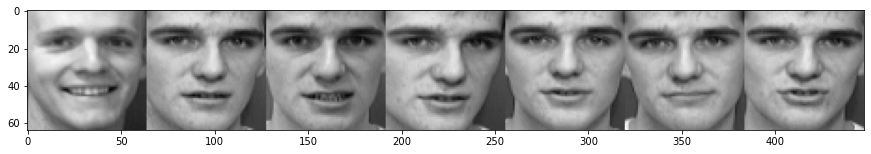

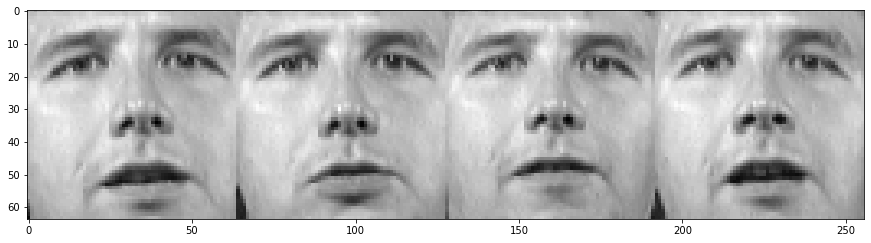

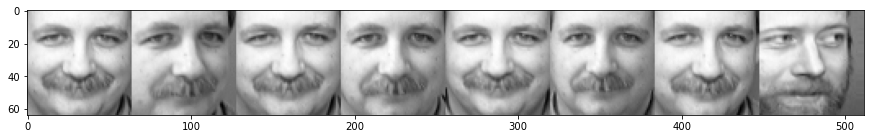

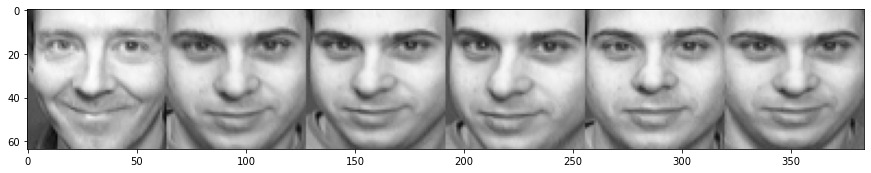

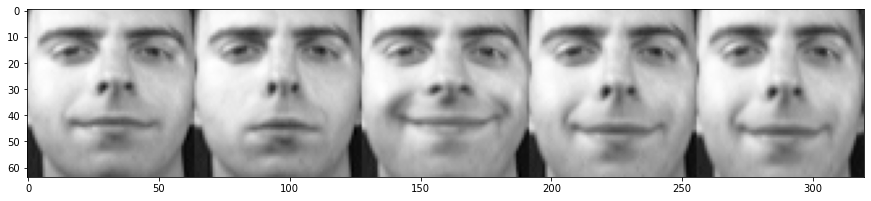

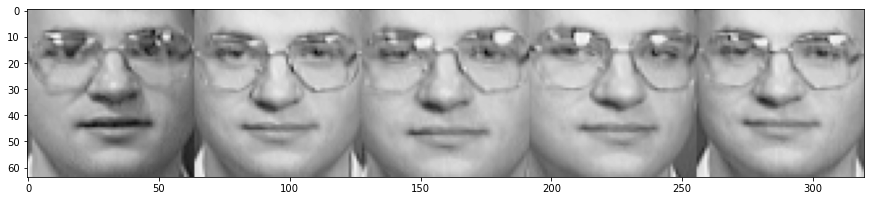

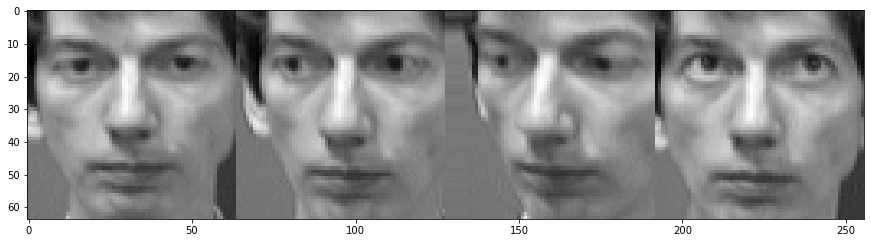

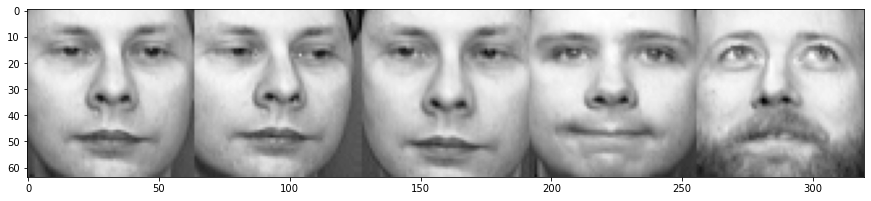

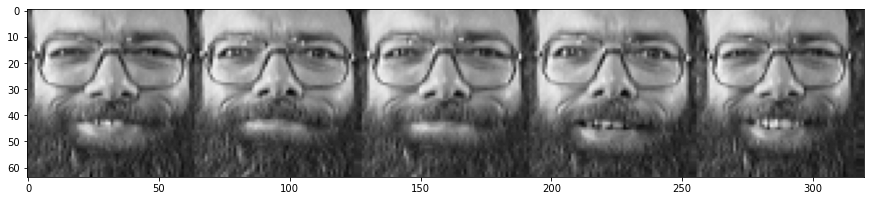

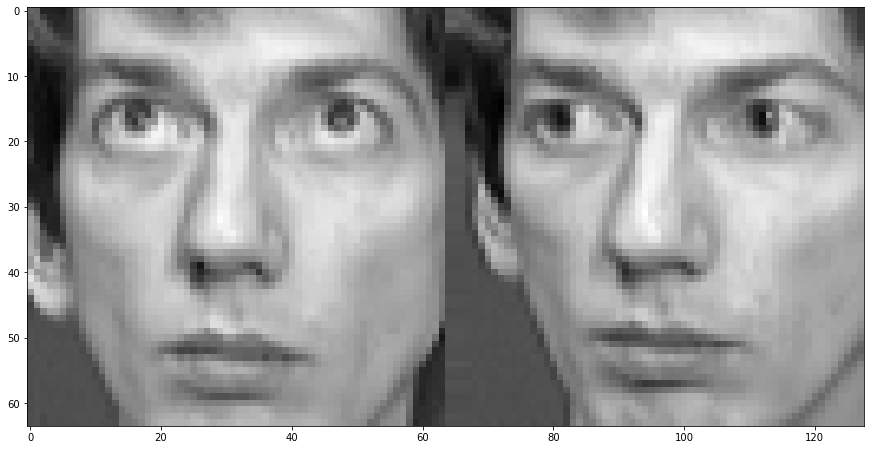

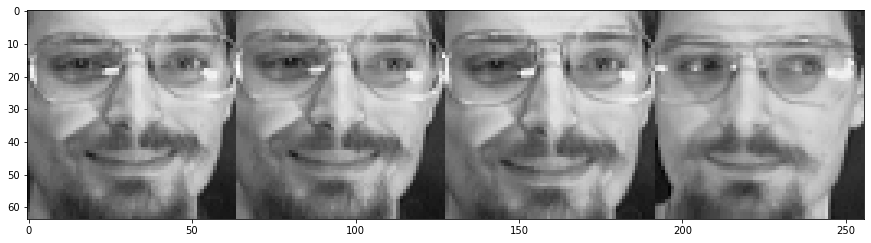

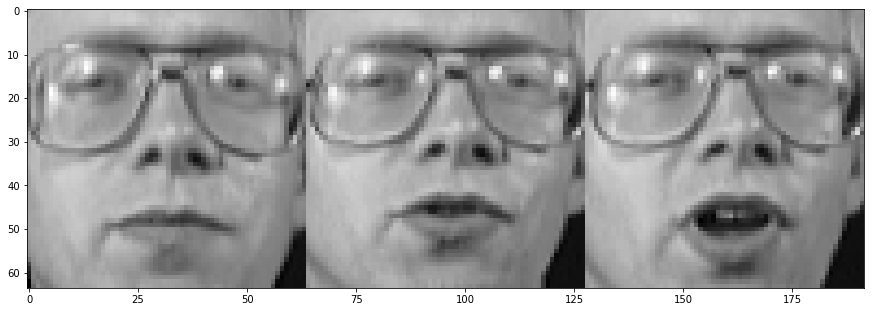

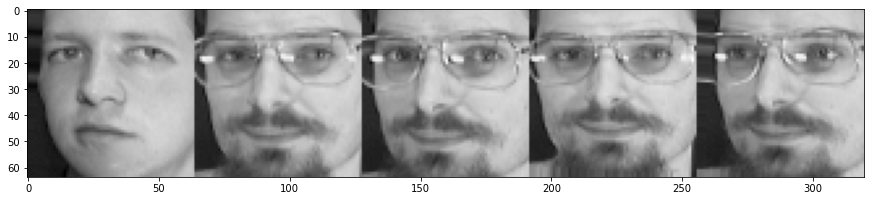

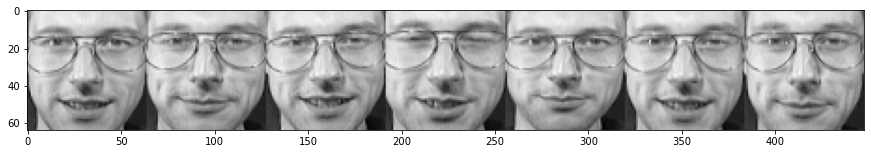

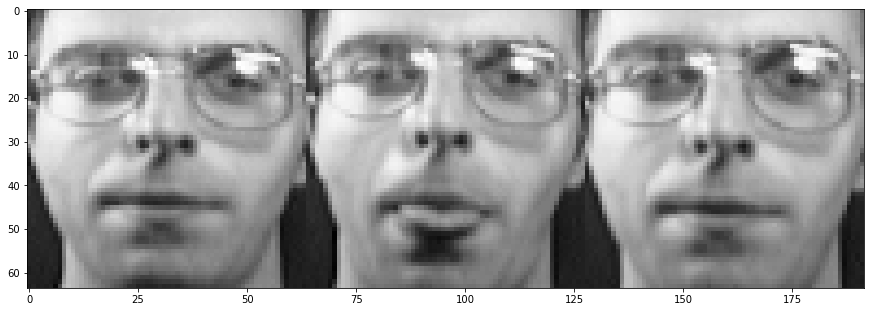

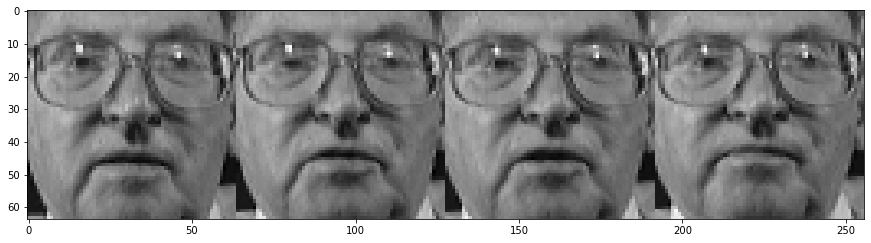

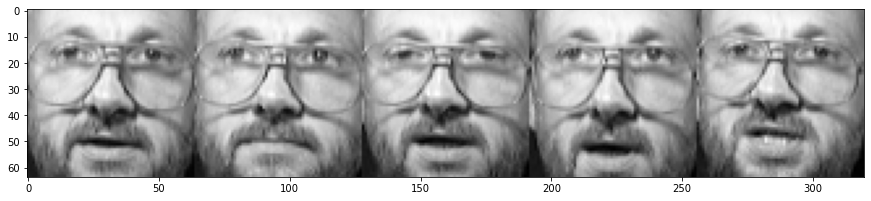

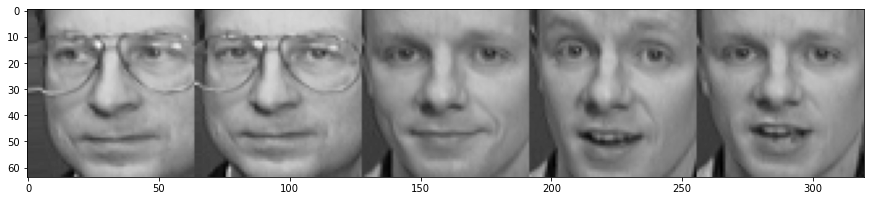

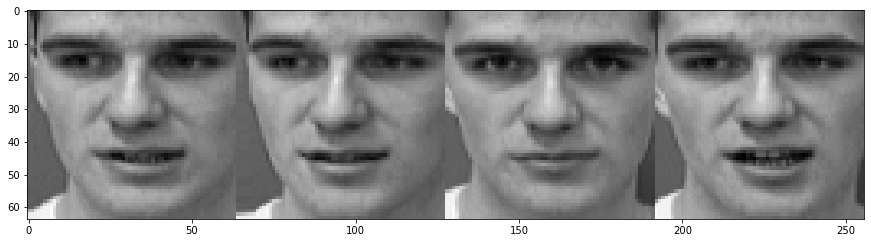

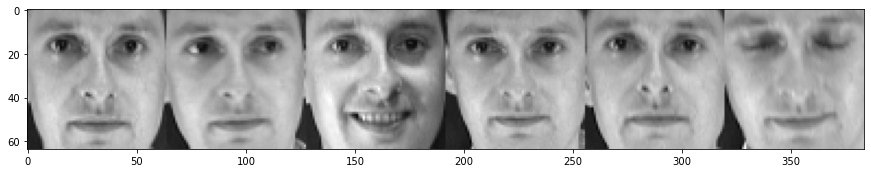

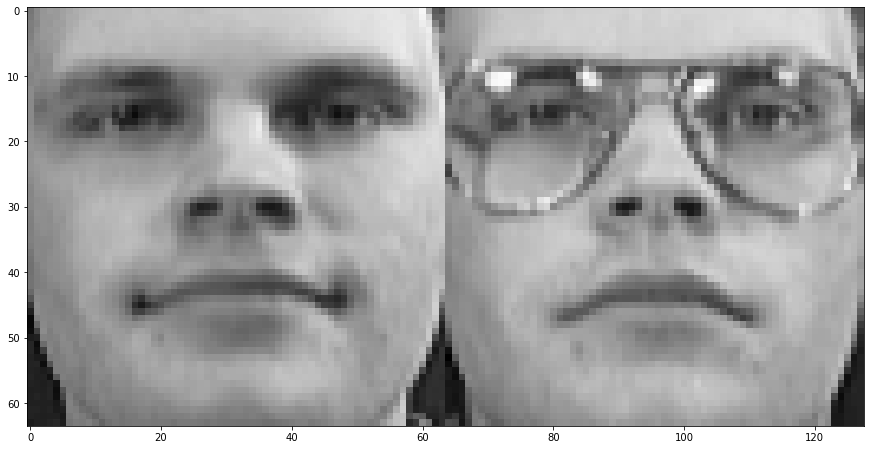

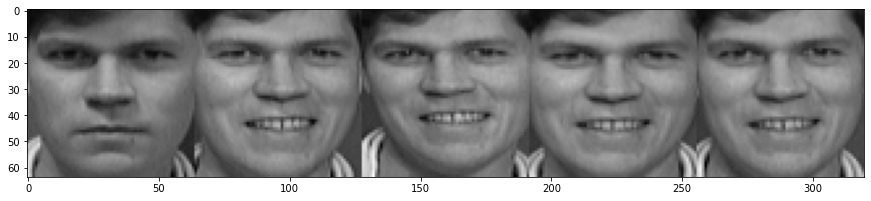

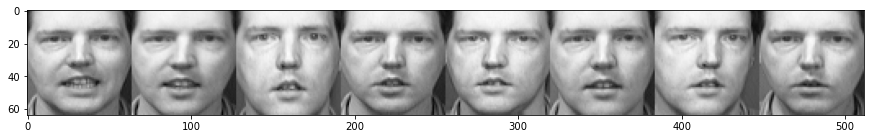

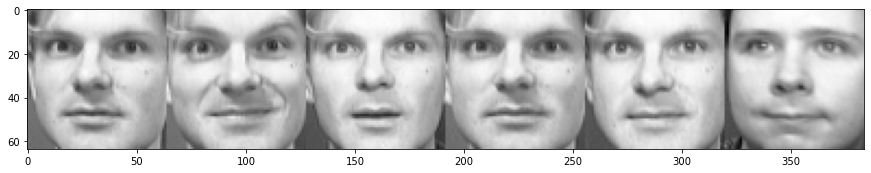

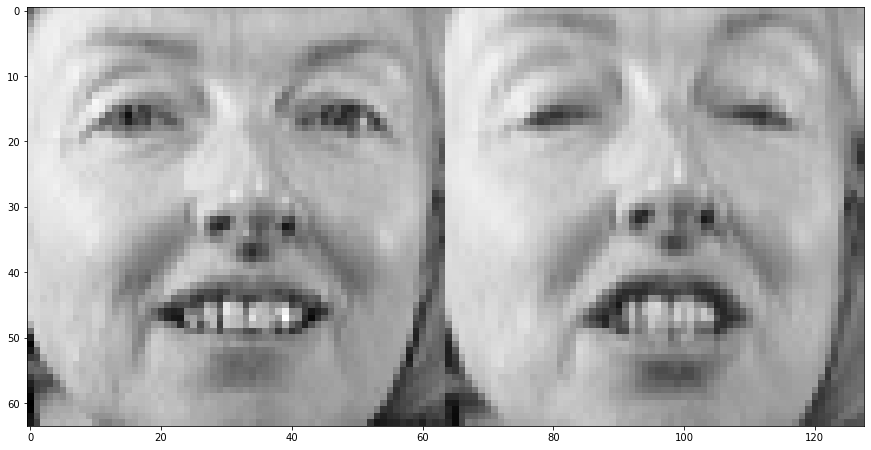

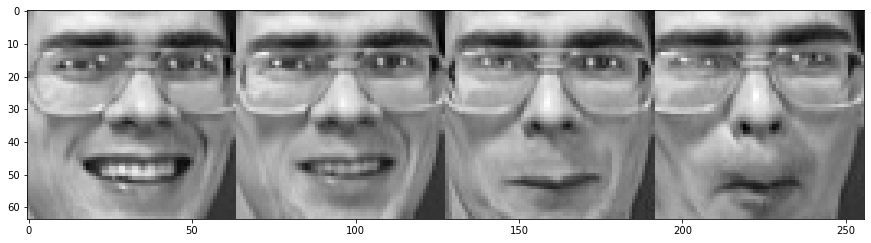

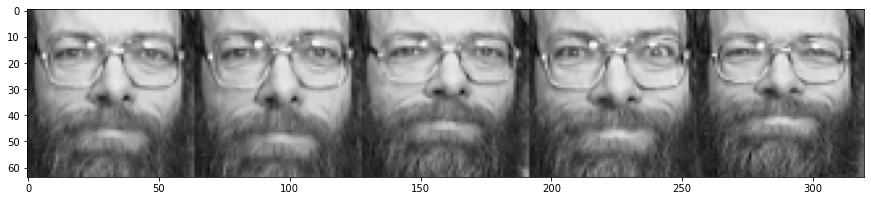

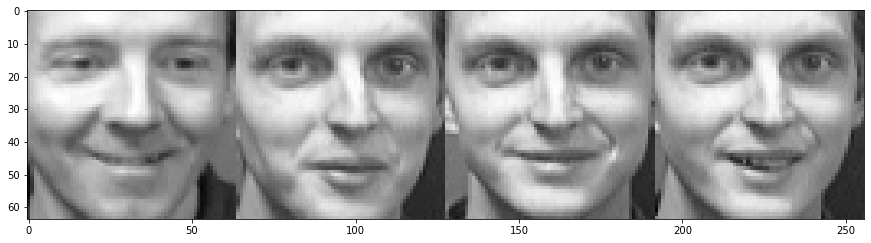

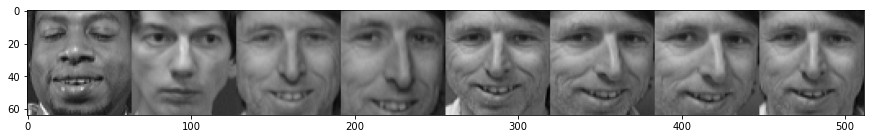

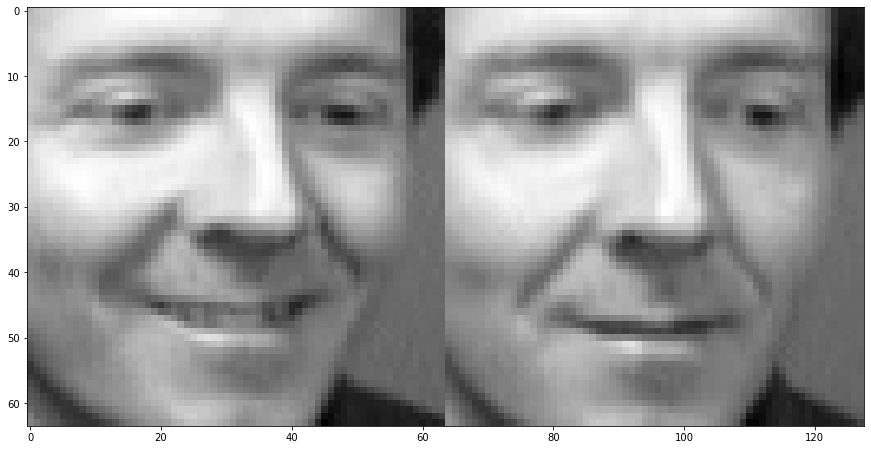

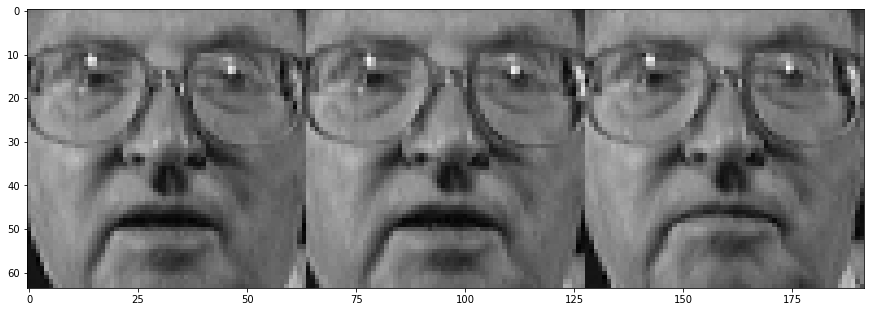

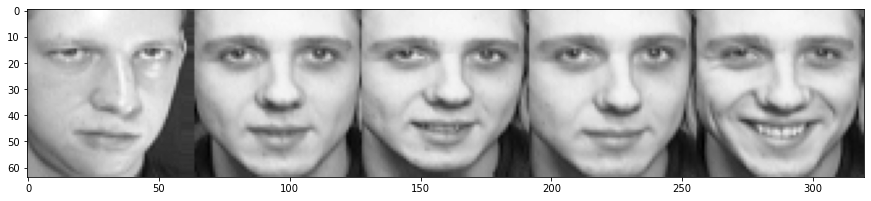

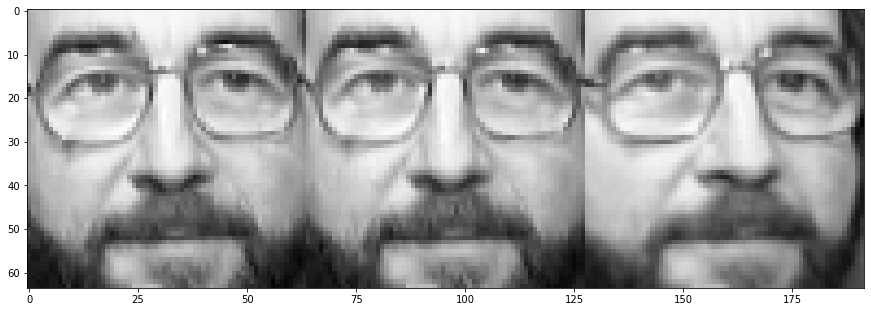

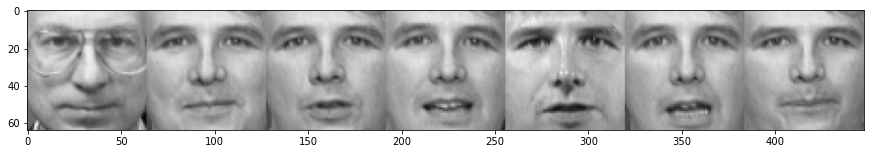

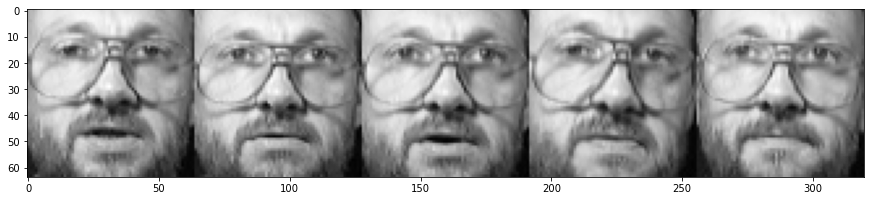

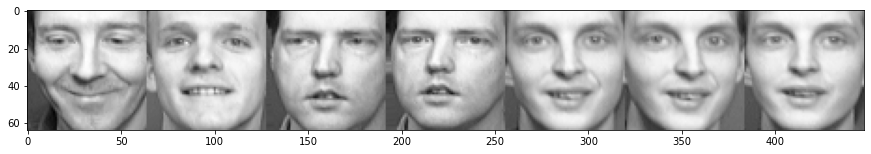

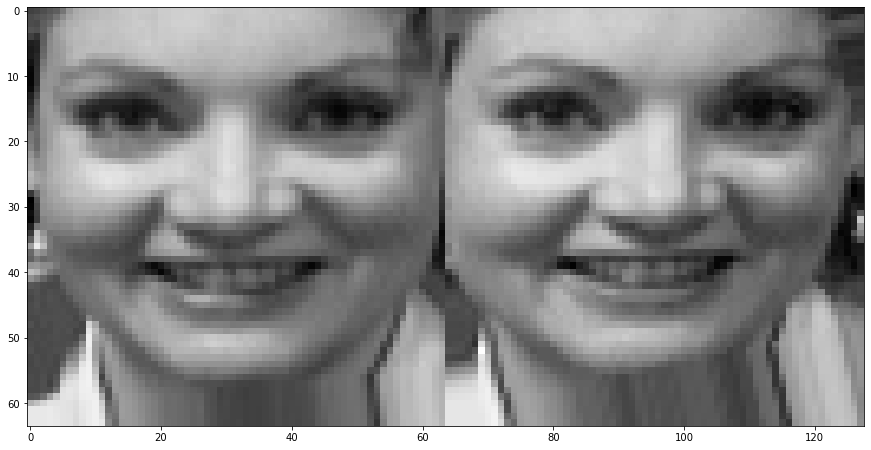

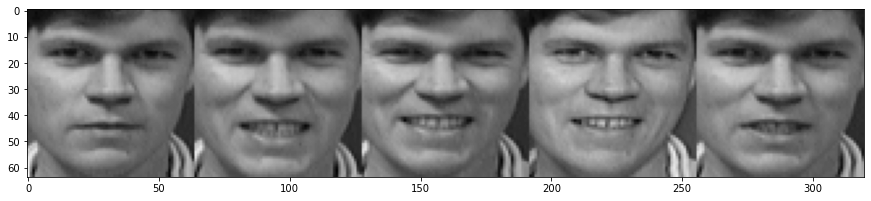

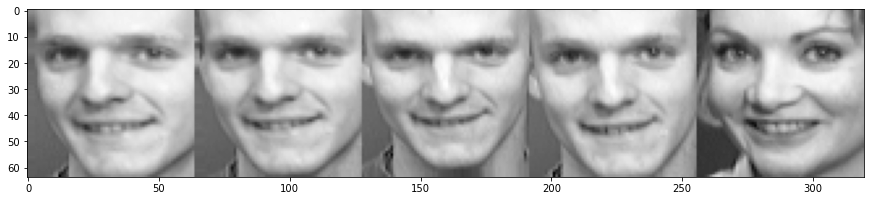

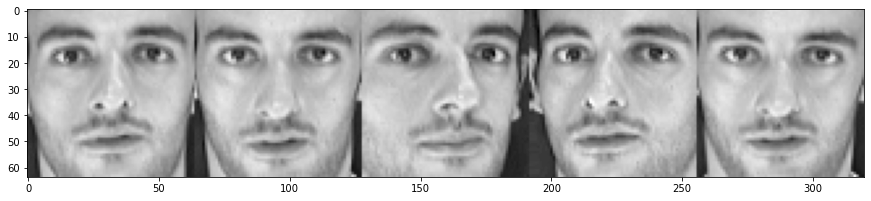

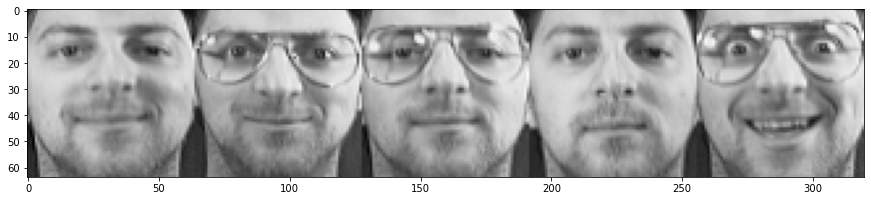

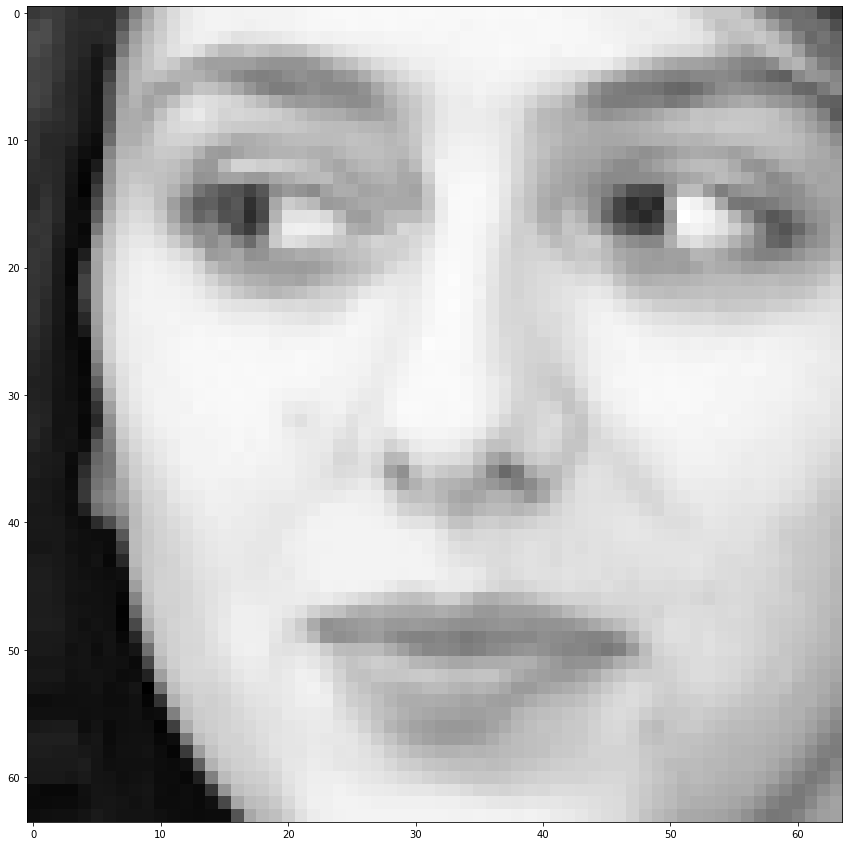

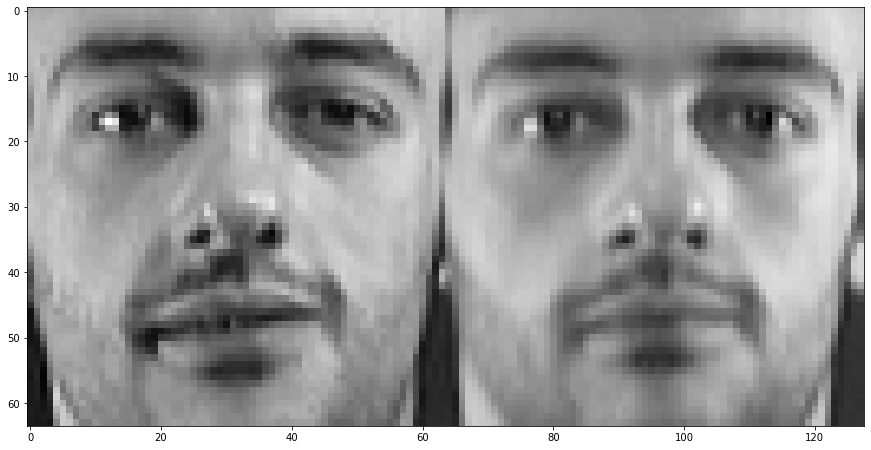

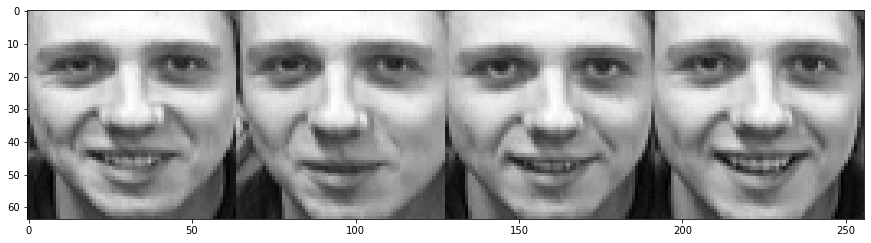

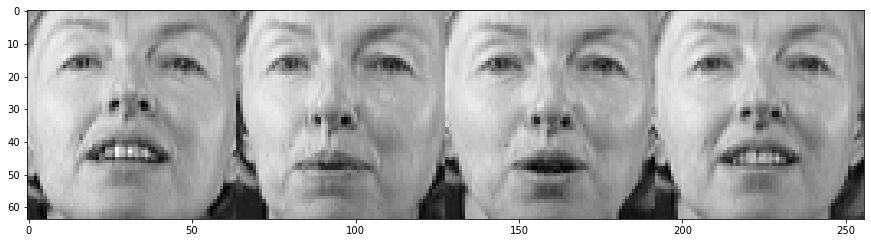

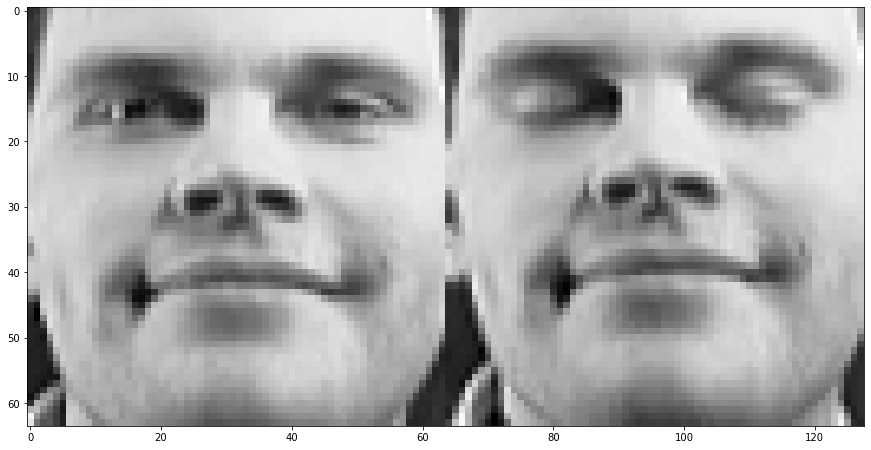

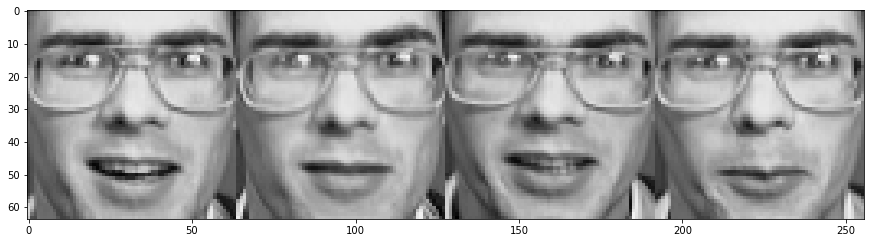

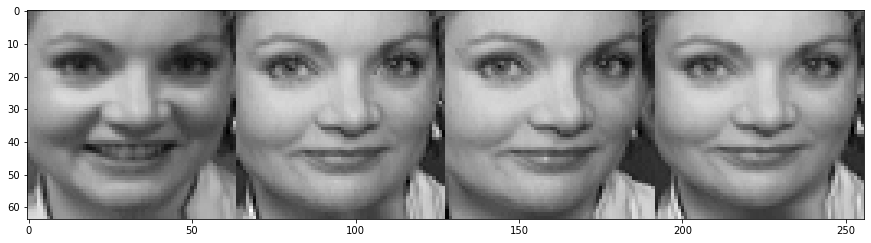

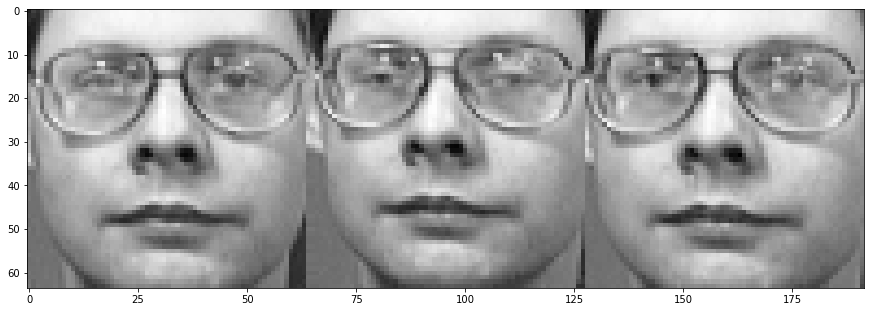

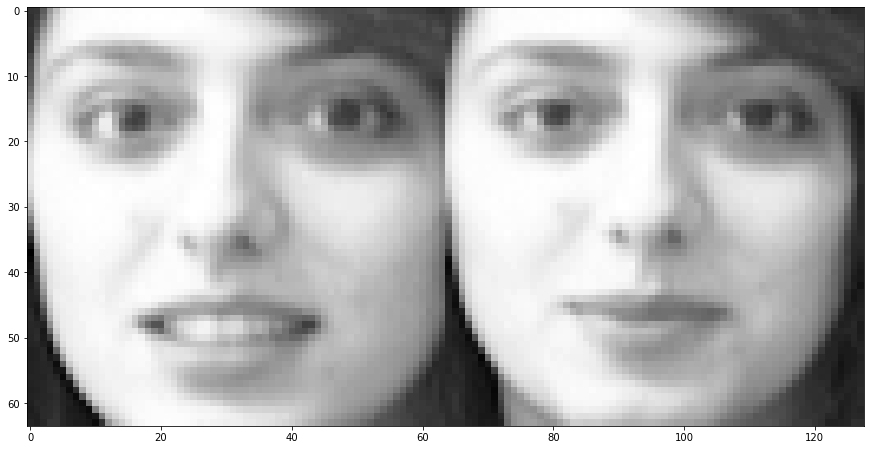

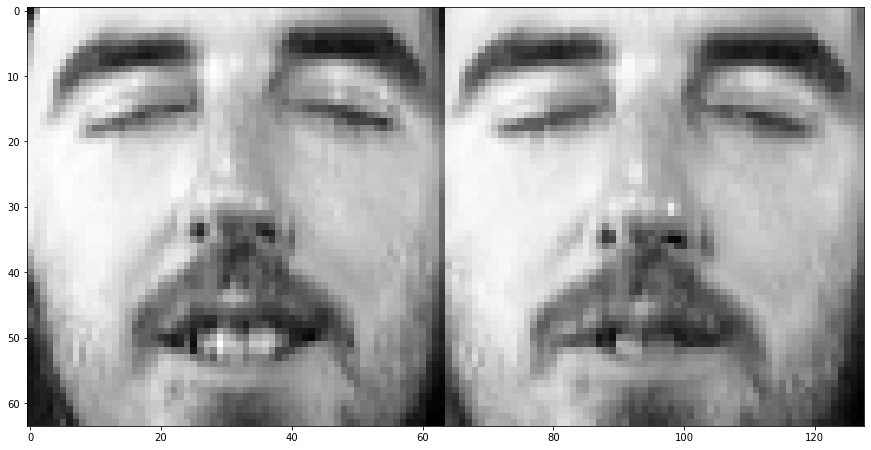

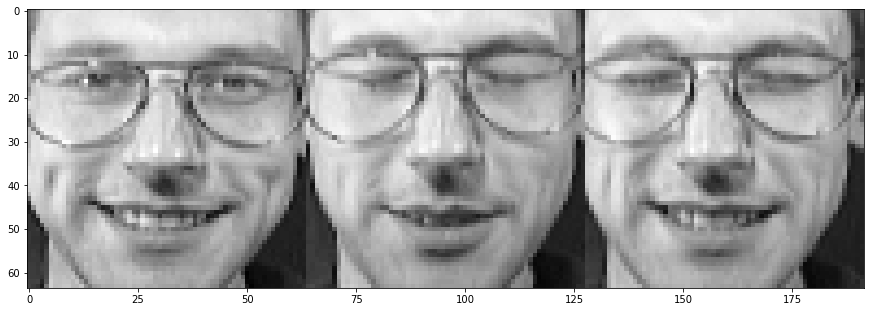

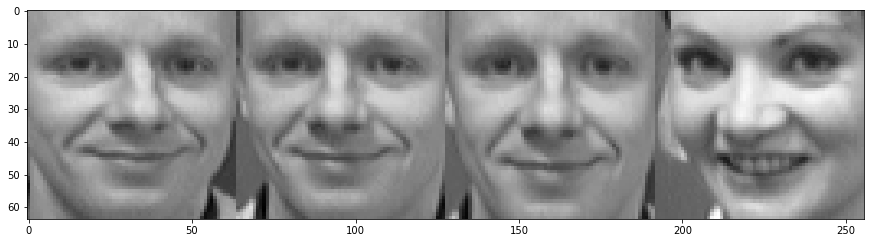

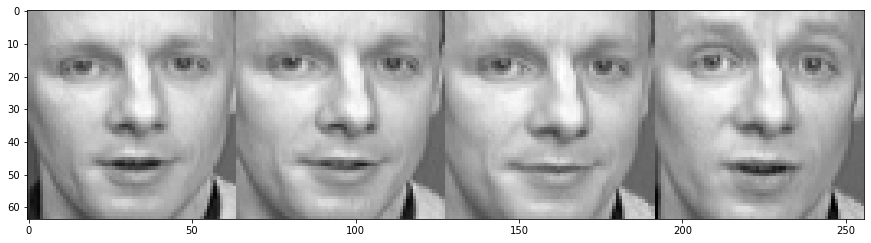

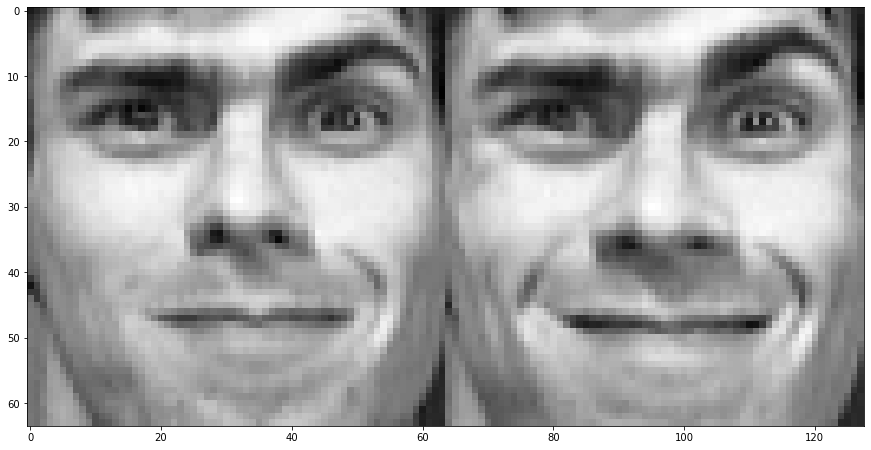

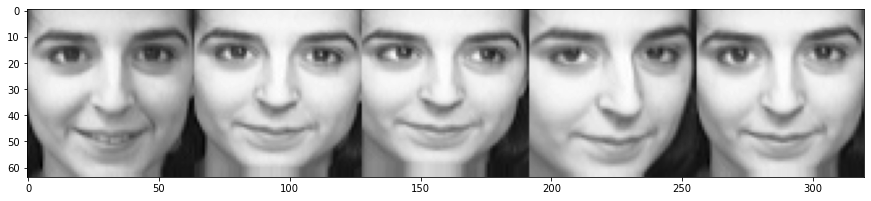

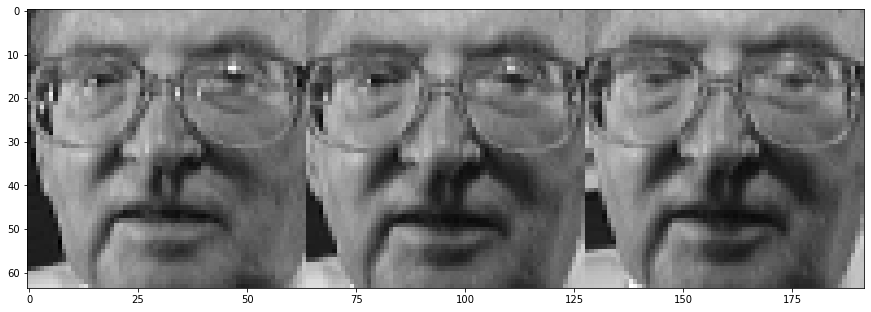

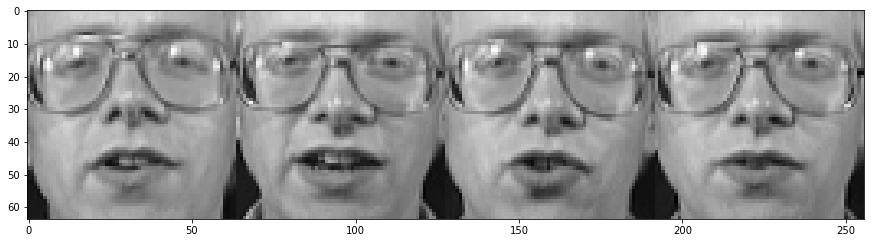

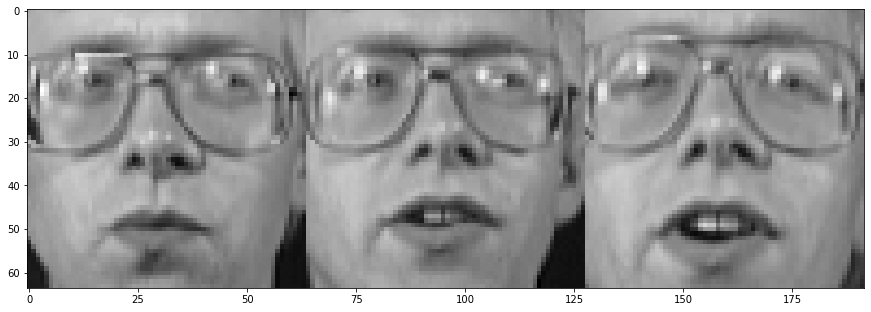

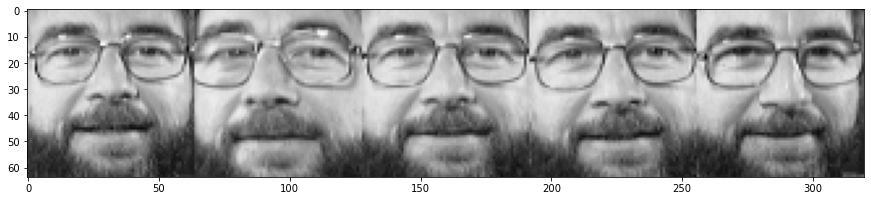

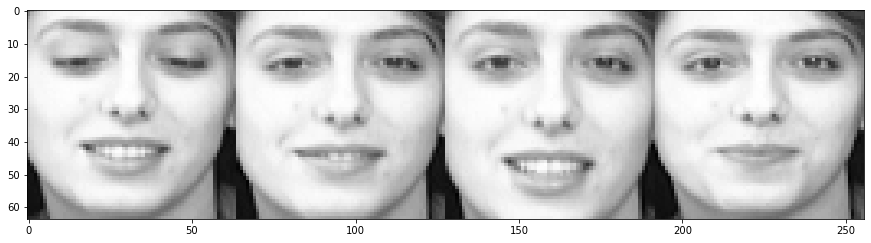

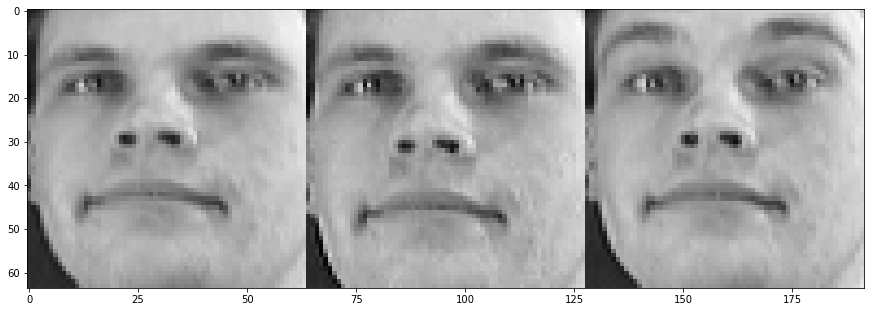

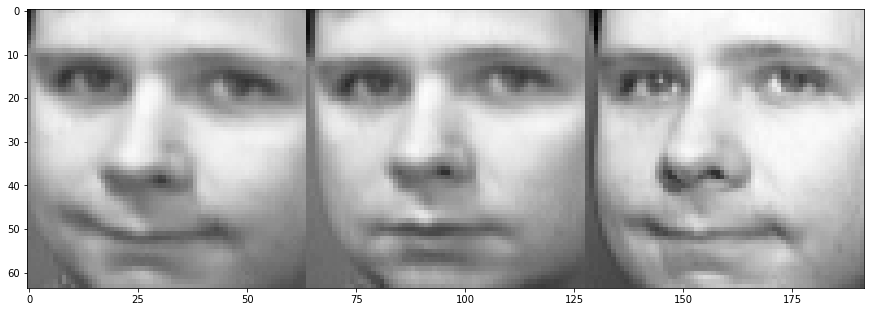

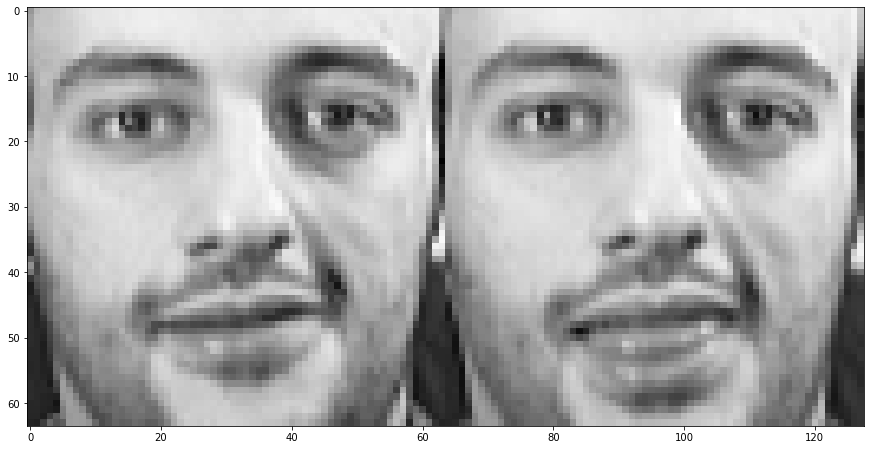

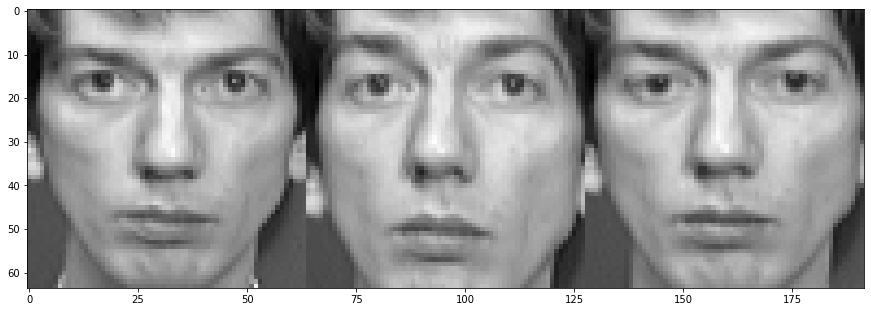

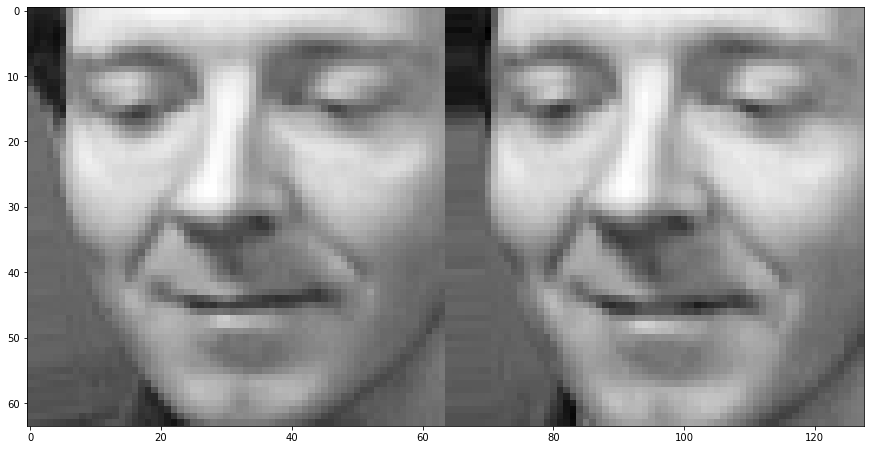

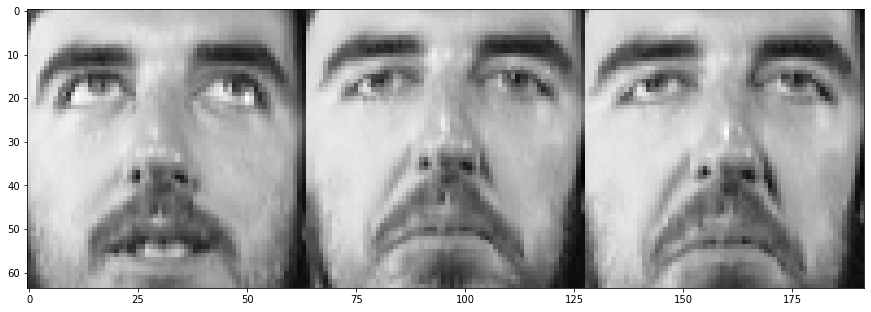

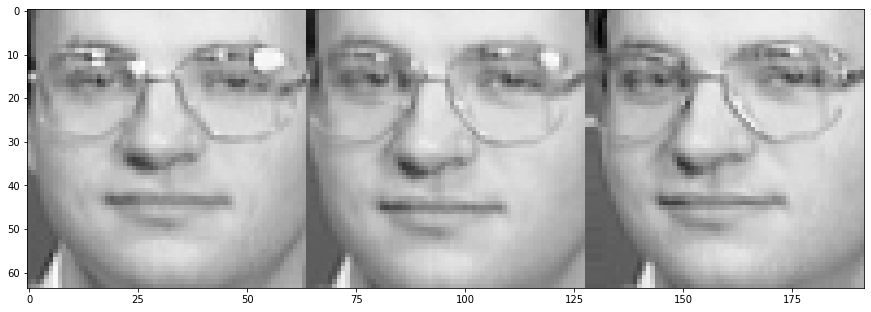

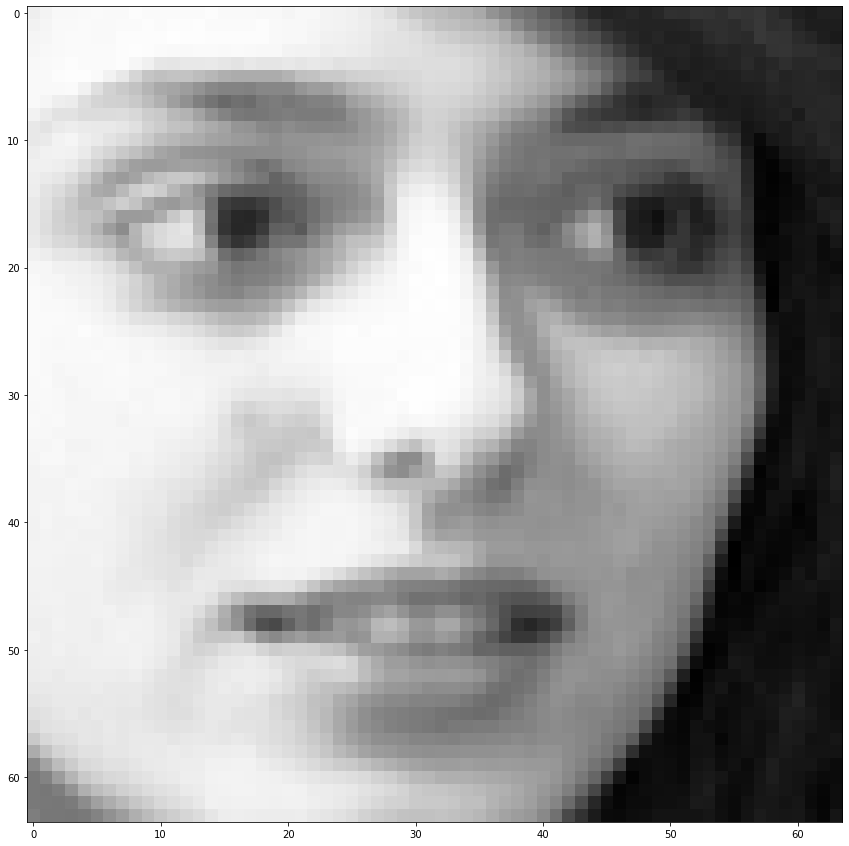

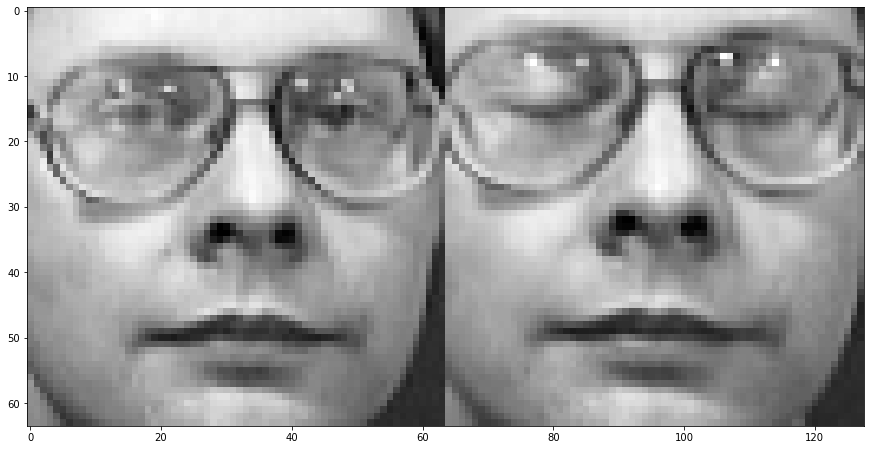

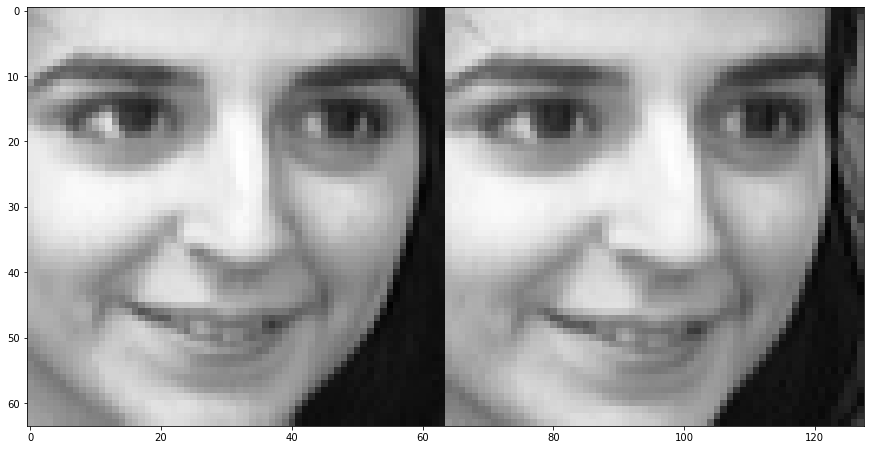

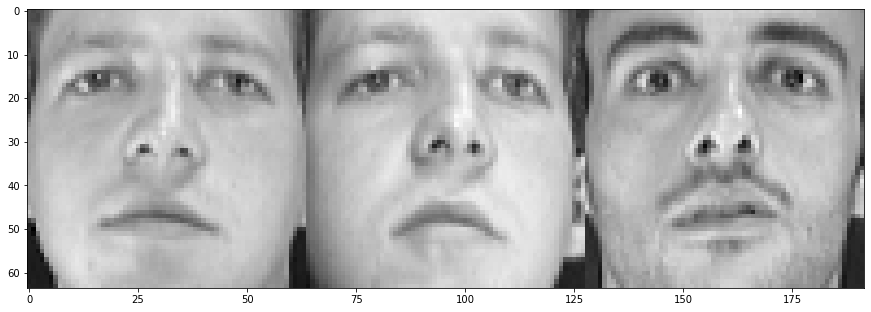

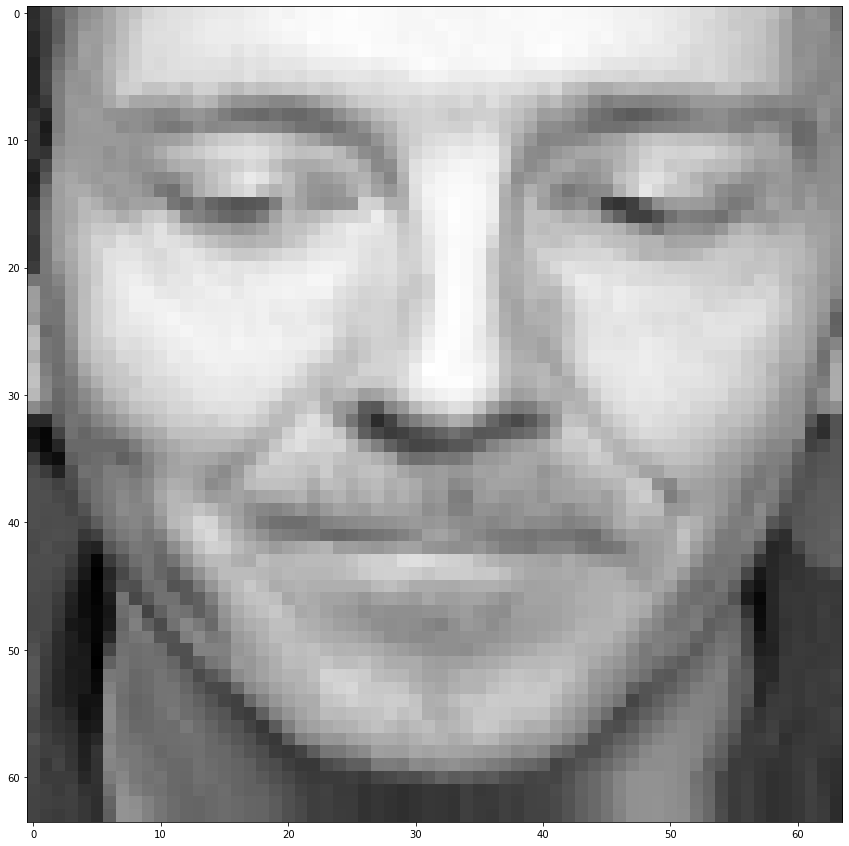

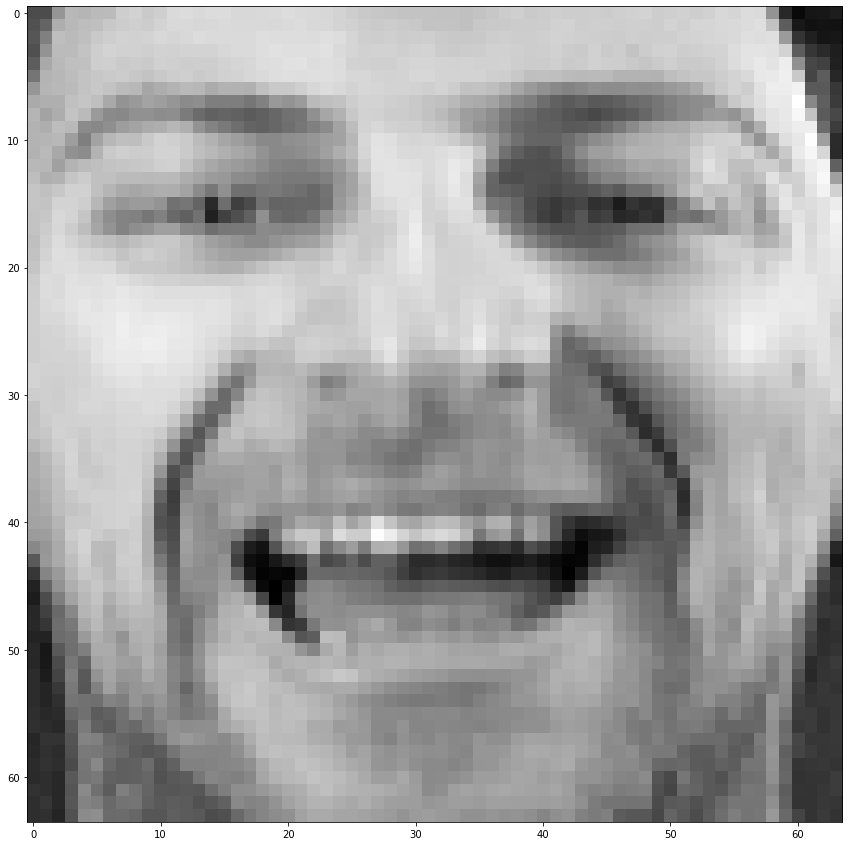

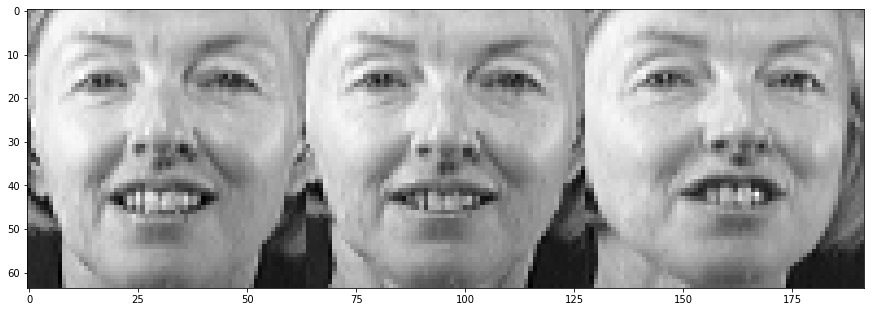

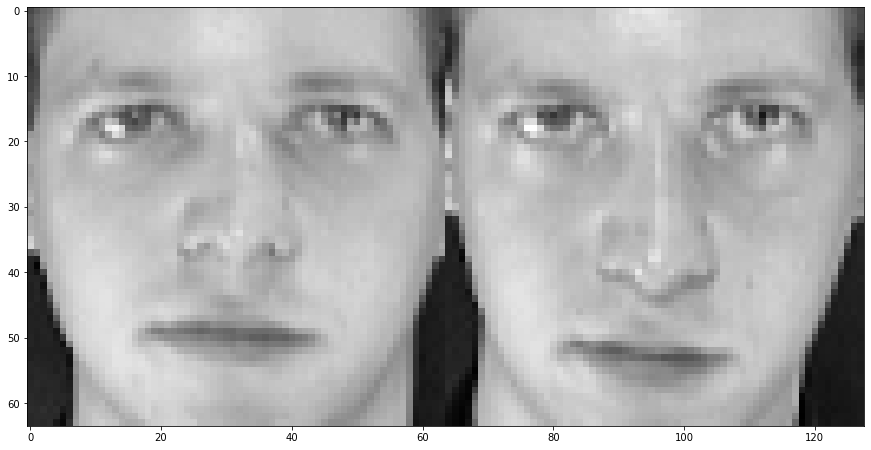

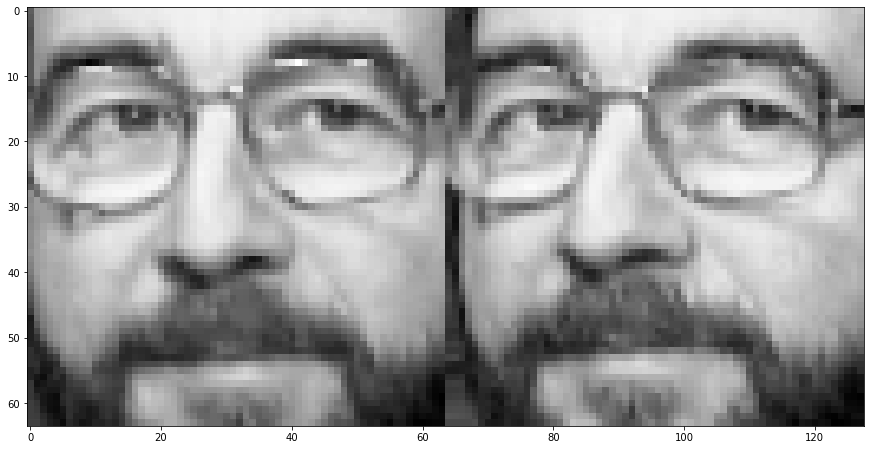

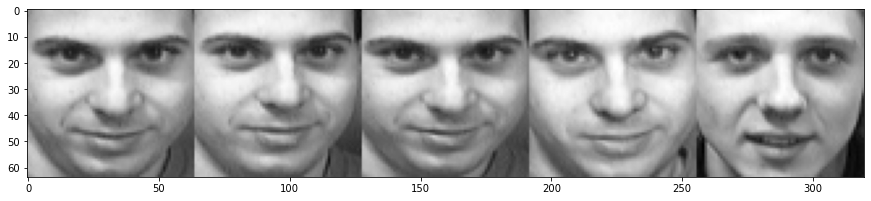

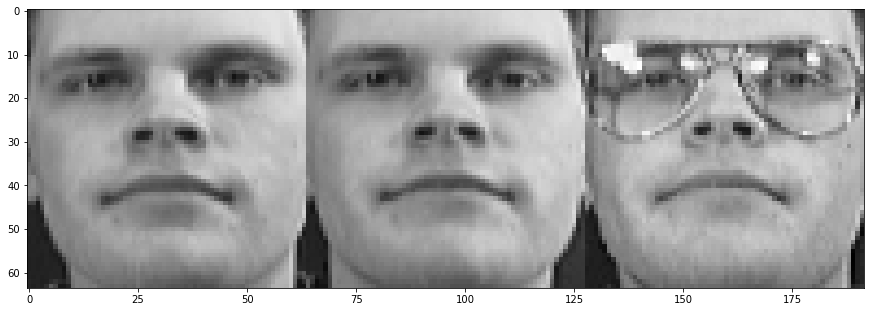

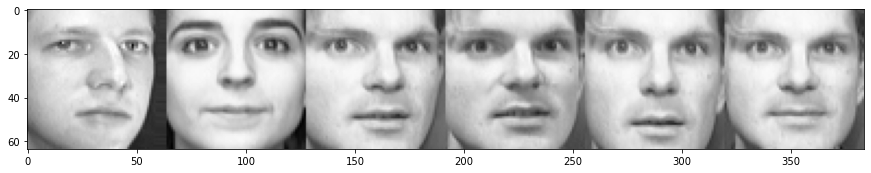

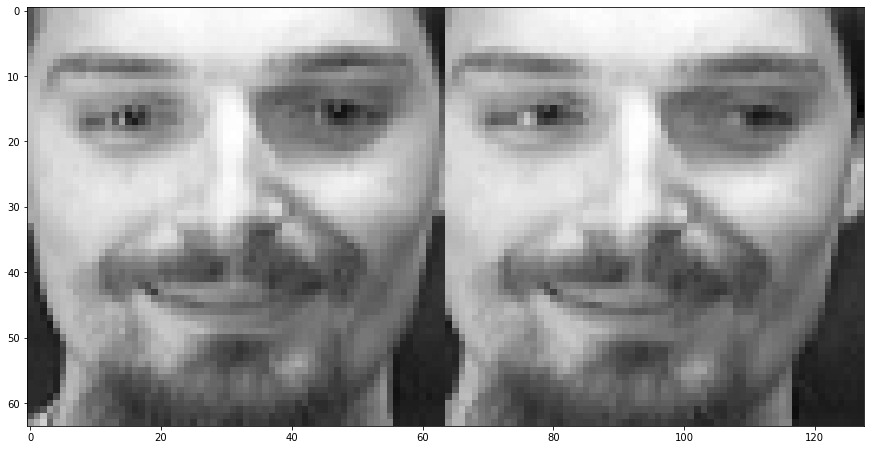

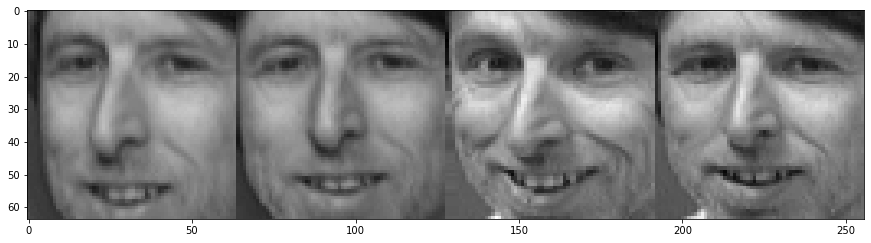

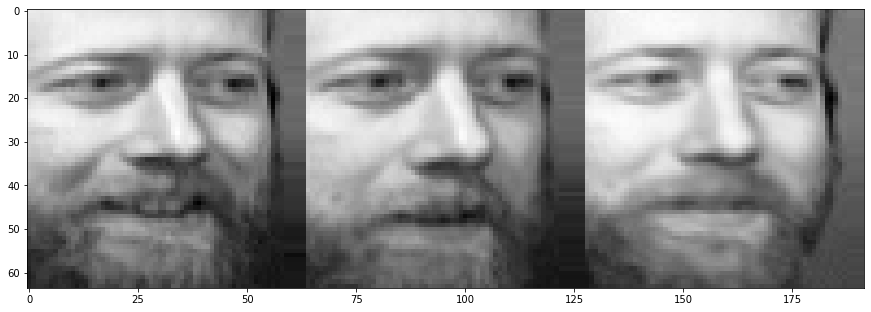

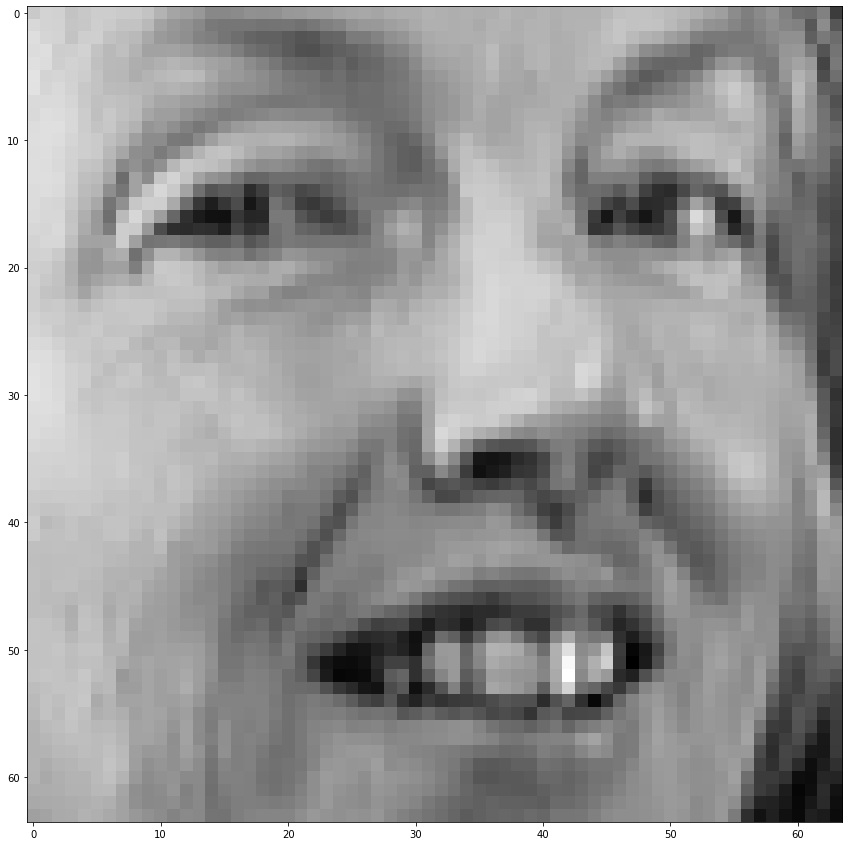

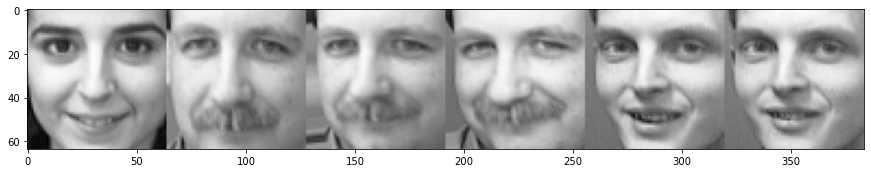

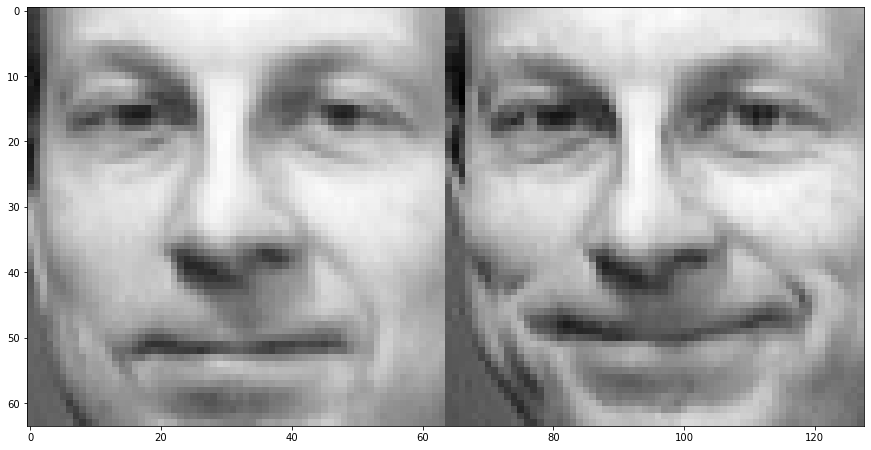

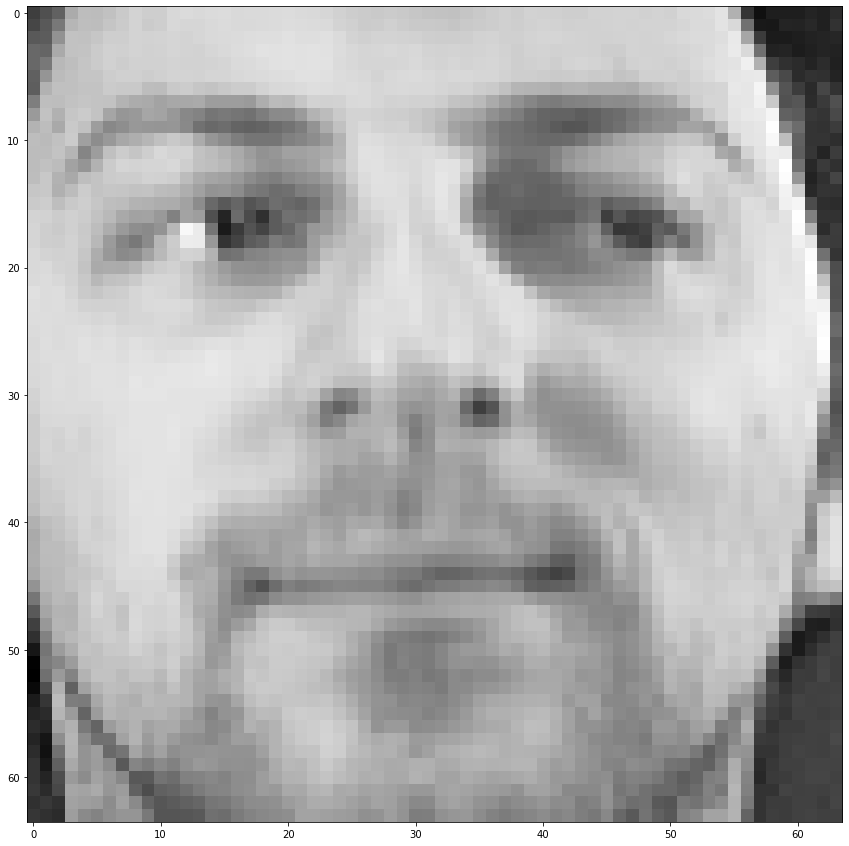

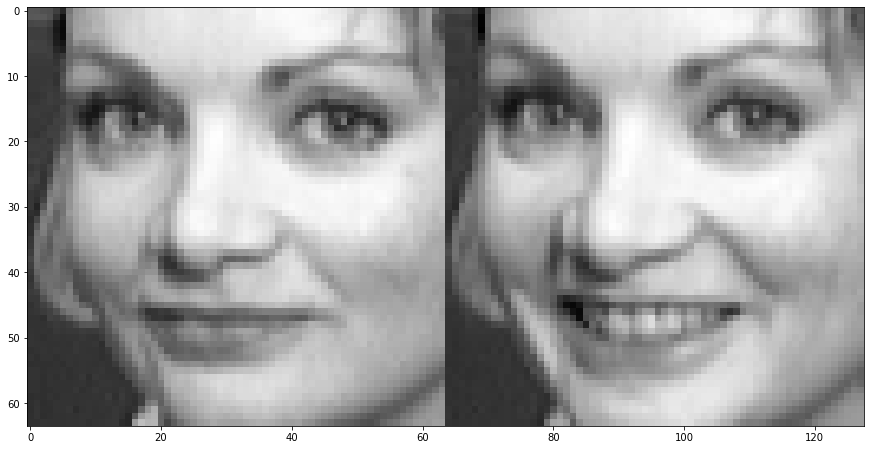

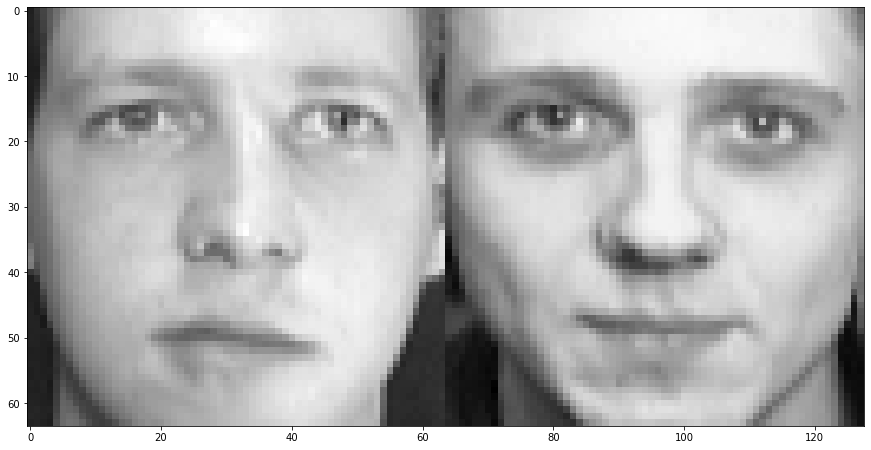

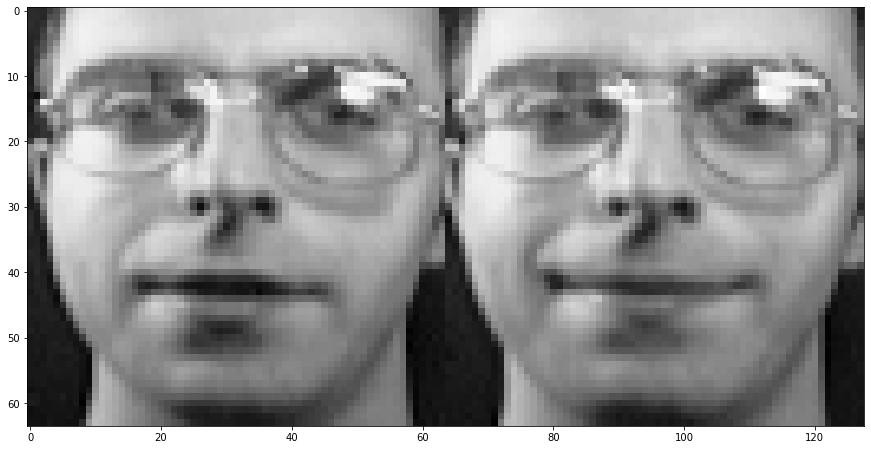

In [7]:
#with 2 clusters
clr = KMeans(n_clusters=best_k,random_state=42) # The dataset is pre-scaled
labels = clr.fit_predict(X)

for k in range(best_k):
    in_cluster = labels == k
    faces = X[in_cluster]
    ls = y[in_cluster]
    show_faces(faces)

Train classifier on pca and compare to classifier on centroid distances

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(max_iter=200)
distributions= dict(C=uniform(loc=0, scale=6))
clf = RandomizedSearchCV(log_reg,distributions,random_state=42, n_iter=20)
best = clf.fit(X_train_pca,y_train)
y_pred = clf.predict(X_valid_pca)
print(f"Log reg accuracy from PCA on validation: {accuracy_score(y_validation,y_pred):.2%}")

Log reg accuracy from PCA on validation: 96.25%


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

pl = Pipeline([
    ("kmeans",KMeans()),
    ("scaler", StandardScaler()),
    ("log_reg",LogisticRegression(max_iter=2000))
    ])

distributions= {
    "kmeans__n_clusters":randint(50,150),
    "log_reg__C":uniform(loc=0, scale=20)
    }

clf_k = RandomizedSearchCV(pl,distributions,random_state=42, n_iter=80, n_jobs=6)

best_k_found = clf_k.fit(X_train_pca,y_train)
y_pred_k = clf_k.predict(X_valid_pca)


print(f"Log reg accuracy from PCA + kmeans on validation: {accuracy_score(y_validation,y_pred_k):.2%}")
print(f"Best parameters found for Kmeans: {best_k_found.best_params_}")

Log reg accuracy from PCA + kmeans on validation: 93.75%
Best parameters found for Kmeans: {'kmeans__n_clusters': 138, 'log_reg__C': 19.312640661491187}


In [10]:
#and for completeness sake here's RFC:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(n_estimators=500)

param_grid_rfc = {
    "max_leaf_nodes": [None,10,20,30,40,100,120,140,160,180,200]
}

best = GridSearchCV(rfc,param_grid_rfc, n_jobs=6).fit(X_train_pca,y_train)

y_pred_rfc = best.predict(X_valid_pca)

print(f"rfc accuracy from PCA on validation {accuracy_score(y_validation,y_pred_rfc):.2%}")
print(f"Best parameters found for RFC: {best.best_params_}")


rfc accuracy from PCA on validation 92.50%
Best parameters found for RFC: {'max_leaf_nodes': None}


* So using centroid distances does NOT improve logistic regression performance on 99% explained variance PCA
* Have already tried this approach on RFC (using MNIST) and found little or no improvement

### Fit GaussianMixture to pca.99

In [11]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=5, random_state=42).fit(X_train_pca)
bgm_preds = bgm.predict(X_valid_pca)
print(bgm_preds)
print(y_validation)

[1 1 1 3 3 4 1 1 1 3 1 2 1 0 0 1 0 0 3 2 1 0 1 0 3 1 0 0 3 2 0 3 0 1 1 3 0
 1 3 0 0 3 1 3 2 2 1 4 4 0 3 3 0 3 1 4 0 2 0 2 1 4 1 4 4 0 0 1 0 0 4 0 3 3
 0 3 1 0 3 4]
[15 17 19 24 31 21  6  6  4 26 12  7 35  8  3 39 37  3 10 17 22 30  9 34
 14 23 37 22 14  7 18 10 20 16  2 38 27  5  1 20  2 23 12 31  9  0 16 33
 28 11 13 26 29 27  8 32 36 24 39  0 19 32  5 33 28 36 25 15 29 11 21 25
 18 30  4 13 35 34  1 38]


###New faces from BGM restricted to 5 mixtures look like a mixture of people (which is to be expected)

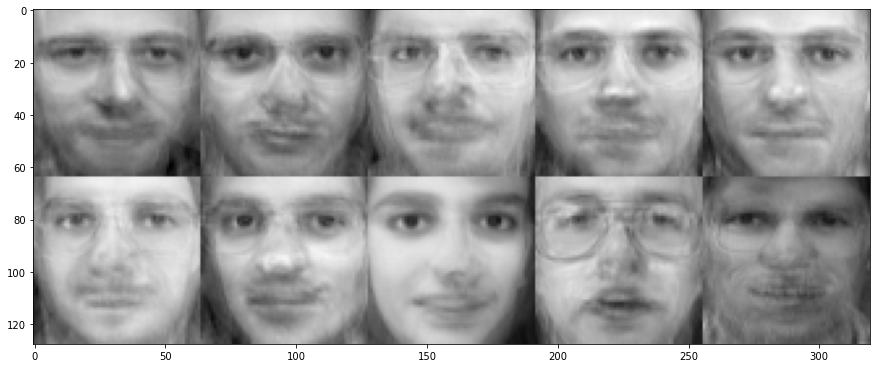

In [12]:
new_faces = []
new_sample = bgm.sample(10)
for _ in new_sample[0]:
    new_faces.append([pca.inverse_transform(_)])
show_faces(np.array(new_faces),5)



In [13]:
bgm50 = BayesianGaussianMixture(n_components=50, random_state=42, n_init=10).fit(X_train_pca)
bgm50_preds = bgm50.predict(X_valid_pca)
print(bgm50_preds)
print(y_validation)

print(f"No of populated mixtures: {len(np.unique(bgm50_preds))}")


[37  6 47  5 41 33 22 29  7 14 11 28 46 44  5 13 32 16 38  6 44  8  6 36
 30 15 32 44 21  1 24 38 36 45 13 39 18 17 12 37 16 19  3 41  3 28 49 31
 43 25 34 14  9 27 44 35 48  5 16 28  9 35 17 31 43 48 44 37  9  9 33 30
  1 26  6 34 46 36 12 39]
[15 17 19 24 31 21  6  6  4 26 12  7 35  8  3 39 37  3 10 17 22 30  9 34
 14 23 37 22 14  7 18 10 20 16  2 38 27  5  1 20  2 23 12 31  9  0 16 33
 28 11 13 26 29 27  8 32 36 24 39  0 19 32  5 33 28 36 25 15 29 11 21 25
 18 30  4 13 35 34  1 38]
No of populated mixtures: 42


### Faces restricted to a maximum of 50 mixtures look better, but still vague in places

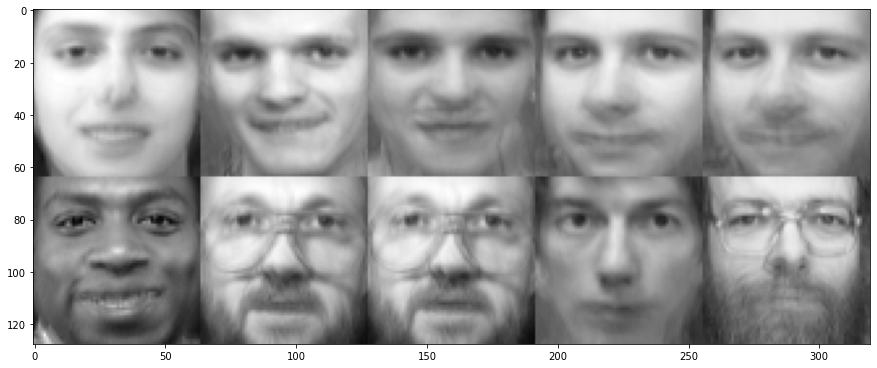

In [14]:
new_faces = []
new_sample = bgm50.sample(10)
for _ in new_sample[0]:
    new_faces.append([pca.inverse_transform(_)])
show_faces(np.array(new_faces),5)

###Faces using up to optimal no of classifications (103):

using optimal number of classifications: 103
[ 67   5  61  23  44 100  42  83  90  17  53  94  54  32  53  36   8  53
  80   5  72  30  34  48  53  45  97  21   9  34  20  14  15  60  15  40
  55  38  22  28  28  10  53  44  37   5  84  18  15  58  29  17  51  46
  36  81  27  23  91  76  28  81  38  18  69  27  21  67  51  37   4  21
   1  31  90  29  39  79  86  40]
[15 17 19 24 31 21  6  6  4 26 12  7 35  8  3 39 37  3 10 17 22 30  9 34
 14 23 37 22 14  7 18 10 20 16  2 38 27  5  1 20  2 23 12 31  9  0 16 33
 28 11 13 26 29 27  8 32 36 24 39  0 19 32  5 33 28 36 25 15 29 11 21 25
 18 30  4 13 35 34  1 38]
No of populated mixtures: 53


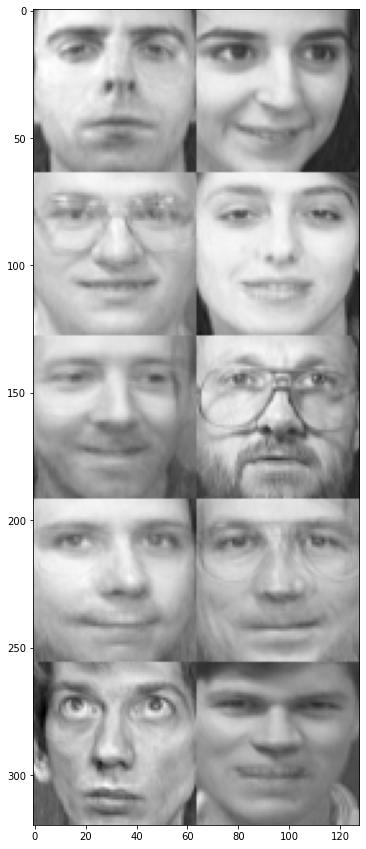

In [15]:
from sklearn.mixture import GaussianMixture
print(f"using optimal number of classifications: {best_k}")
gm103 = GaussianMixture(n_components=best_k, random_state=42).fit(X_train_pca)
gm103_preds = gm103.predict(X_valid_pca)
print(gm103_preds)
print(y_validation)
new_faces = []
new_sample = gm103.sample(10)
print(f"No of populated mixtures: {len(np.unique(gm103_preds))}")
for _ in new_sample[0]:
    new_faces.append([pca.inverse_transform(_)])
show_faces(np.array(new_faces),2)

### Training on the whole dataset with unlimited no of components
* 80 populated mixtures - compared to 40 individuals


[388 229  94 328 233  69 184  37 297  20 279 204 157 307 248 391 115   5
 320 171 140 145  98  46 325 344 205 355 345  33 333 135 260 352 373 203
  30 359 123 245 103 375 338  51  65 177  50 383 129  54 179  82 322 216
 266 365 238 187   8 121  67  68  18  22  93  14  76  44 384 280 176 156
 201  29  63 351  42 368 379 296]
[15 17 19 24 31 21  6  6  4 26 12  7 35  8  3 39 37  3 10 17 22 30  9 34
 14 23 37 22 14  7 18 10 20 16  2 38 27  5  1 20  2 23 12 31  9  0 16 33
 28 11 13 26 29 27  8 32 36 24 39  0 19 32  5 33 28 36 25 15 29 11 21 25
 18 30  4 13 35 34  1 38]
max no of components: 400
length of training set: 400
No of populated mixtures: 80


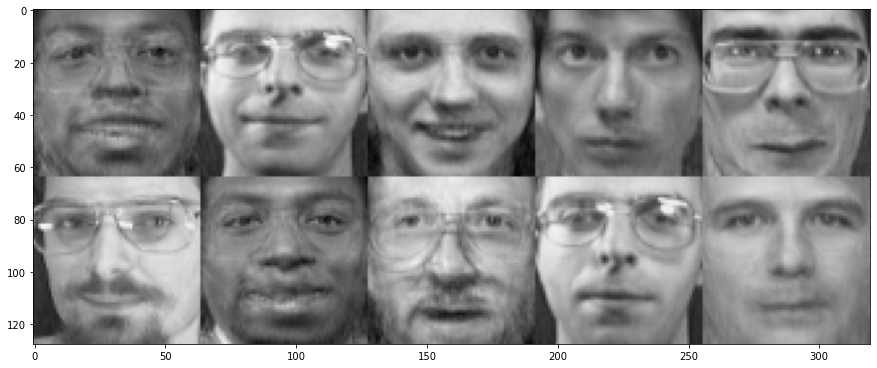

In [16]:
#Training on the whole dataset
X_pca = np.concatenate((X_train_pca,X_valid_pca,X_test_pca),axis=0)
gm103 = GaussianMixture(n_components=400).fit(X_pca)
gm103_preds = gm103.predict(X_valid_pca)
print(gm103_preds)
print(y_validation)
new_faces = []
new_sample = gm103.sample(10)
print(f"max no of components: 400")
print(f"length of training set: {len(X_pca)}")
print(f"No of populated mixtures: {len(np.unique(gm103_preds))}")

for _ in new_sample[0]:
    new_faces.append([pca.inverse_transform(_)])
show_faces(np.array(new_faces),5)

## Novelty / anomaly detection using GM.score_samples:
Comparing:
* Log-likelihood for actual sample from the fitted data
* LL for new samples generated from the GM for the whole of X:
    * on the GM for the whole of X
    * on the GM for X_train only

In [17]:
#Create BGM on the training data only
train_GM = BayesianGaussianMixture(n_components=50, random_state=42, n_init=10).fit(X_train_pca)
#Score data generated from the BGM for the whole dataset

print(f"log likelihood for a genuine sample from the GM fitted on X {gm103.score_samples(np.array(X_train_pca)[0:10])}")
print(f"\nlog likelihood for the generated samples on the GM fitted on X:\n {gm103.score_samples(np.array(new_sample[0]))}")
print(f"\nlog likelihood for a genuine sample from the GM fitted on X_train only {gm103.score_samples(np.array(X_train_pca)[0:1])}")
print(f"\nlog likelihood for the generated samples scored with the GM fitted on X_train only \n{train_GM.score_samples(np.array(new_sample[0]))}")
print(f"\nLL for unseen real image from validation set scored with the GM fitted on X_train only \n{train_GM.score_samples(np.array(X_valid_pca)[0:10])}")

log likelihood for a genuine sample from the GM fitted on X [1054.02909946 1054.02909946 1054.02909946 1054.02909946 1054.02909946
 1054.02909946 1054.02909946 1054.02909946 1054.02909946 1054.02909946]

log likelihood for the generated samples on the GM fitted on X:
 [978.00258869 969.56728066 958.9305461  977.05028401 966.73676732
 964.19940084 956.04759525 964.40927513 963.54586634 965.09031334]

log likelihood for a genuine sample from the GM fitted on X_train only [1054.02909946]

log likelihood for the generated samples scored with the GM fitted on X_train only 
[-10235.06758166    312.3873285   -6896.5451043     311.53636234
    311.83871625    312.03915254  -6243.47022658 -13956.70160647
    311.73361112  -2566.81449424]

LL for unseen real image from validation set scored with the GM fitted on X_train only 
[ -6958.41204041  -3897.46411706  -9117.42534393  -3394.72002729
 -11555.94230331  -3075.67955238 -14295.24390793 -11535.3100293
  -8851.35391118  -7818.41720273]


* Unseen images have LL ranging from -3k to -11k
* but artificially darkened images have LL < - 20 Million!:


 Artificially darkened images:


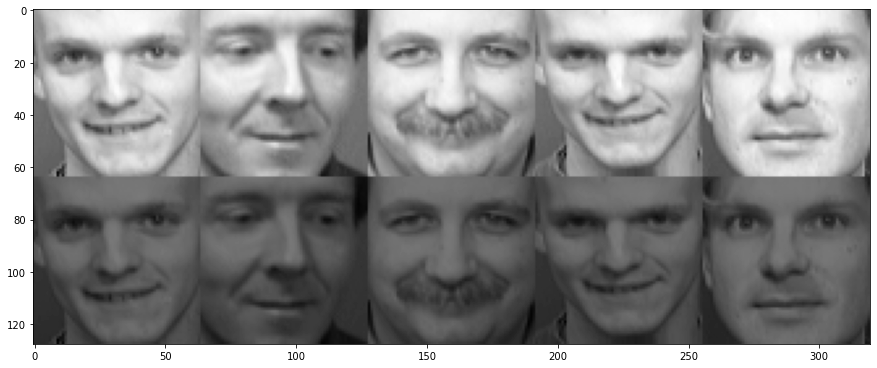

log likelihood for darkened training samples from the GM fitted on X [-31665740.44872322 -49564206.59680822 -34725723.17320906
 -38755304.91948709 -21539621.83556795 -53370256.27034235
 -42429109.06707612 -85252785.54176068 -33006534.74324547
 -88386571.30756725]


In [18]:
X_train_dark = [X_train[_]*0.5 for _ in range(len(X_train))]

print("\n Artificially darkened images:")

light = np.array(X_train[0:5])
dark = np.array(X_train_dark[:5])
show_faces(np.concatenate((light,dark)),5)


X_train_dark_pca = pca.transform(X_train_dark)

print(f"log likelihood for darkened training samples from the GM fitted on X {gm103.score_samples(np.array(X_train_dark_pca)[0:10])}")

The PCA reconstruction error is much greater for the darkened versions of the training images than for the original images
* Graph shows reconstruction error for the modified images compared to the original - Dashed line shows ratio of 1
* more than 5 times worse in many cases

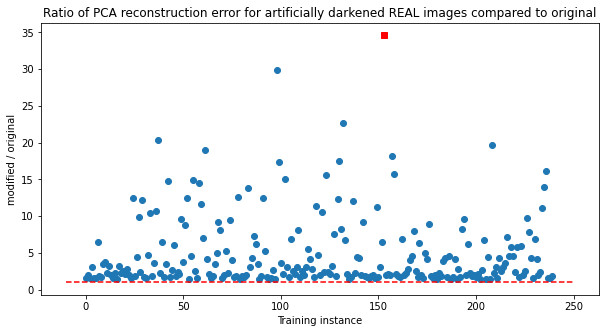

In [22]:
def reconstruction_error(original, _pca):
    from sklearn.metrics import mean_squared_error
    compressed = _pca.transform(original.reshape(1, -1))
    reconstructed = _pca.inverse_transform(compressed).reshape(original.shape)
    return mean_squared_error(original,reconstructed)

original_errors = [reconstruction_error(_,pca) for _ in X_train]
dark_errors = [reconstruction_error(_,pca) for _ in X_train_dark]

error_ratio = [dark_errors[_]/ original_errors[_] for _ in range(len(X_train))]

max_error = max(error_ratio)
worst_case = np.argmax(error_ratio)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.xlabel("Training instance")
plt.ylabel("modified / original")
plt.hlines(1,-10,len(error_ratio)+10,"r",linestyles="dashed")
plt.title("Ratio of PCA reconstruction error for artificially darkened REAL images compared to original")
plt.scatter(range(len(error_ratio)),error_ratio)
plt.plot(worst_case,max_error,"rs")
plt.show()


Following shows reconstruction error for the worst case - shape is correct, but complexion is very blotchy

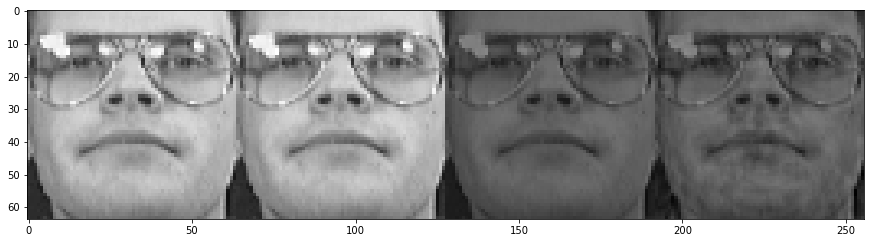

In [20]:
compressed = pca.transform(X_train[worst_case].reshape(1, -1))
reconstructed = pca.inverse_transform(compressed).reshape(X_train[worst_case].shape)

compressed = pca.transform(X_train_dark[worst_case].reshape(1, -1))
reconstructed_dark = pca.inverse_transform(compressed).reshape(X_train[worst_case].shape)
show_faces(np.array([X_train[worst_case],reconstructed,X_train_dark[worst_case],reconstructed_dark]),4)